## Imports

In [1]:
import pandas as pd
pd.plotting.register_matplotlib_converters() 
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import os
import re
import json
from datetime import datetime

from sklearn.ensemble import IsolationForest


from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResultsWrapper
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json
from pmdarima import auto_arima
from pmdarima.arima import ARIMA
from pylab import rcParams

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings 
warnings.filterwarnings("ignore")


import calendar
import pickle


# Deep learning
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping


d:\Python Projects\fast_api\forecasting_task\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('train_1.csv')
df.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN         NaN   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-09  ...  2016-12-22  2016-12-23  2016-12-24  2016-12-25  \
0        26.0  ...        32.0        63.0        15.0        26.0   
1        10.0  ...        17.0        42.0        28.0        15.0   
2         4.0  ...         3.0         1.0         1.0         7.0   
3        11.0  ...        32.0        10.0        26.0        27.0   
4         NaN  ...        48.0         9.0        25.0        13.0   

   2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
0        14.0        20.0        22.0        19.0        18.0        20.0  
1         9.0        30.0        52.0        45.0        26.0        20.0  
2         4.0         4.0         6.0         3.0         4.0        17.0  
3        16.0        11.0        17.0        19.0        10.0        11.0  
4         3.0        11.0        27.0        13.0        36.0        10.0  

[5 rows x 551 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [4]:
df = df.fillna(0)

In [5]:
df_reshaped = pd.melt(df, id_vars=['Page'], var_name='Date', value_name='Views')
df_reshaped.head()

Page        Date  Views
0            2NE1_zh.wikipedia.org_all-access_spider  2015-07-01   18.0
1             2PM_zh.wikipedia.org_all-access_spider  2015-07-01   11.0
2              3C_zh.wikipedia.org_all-access_spider  2015-07-01    1.0
3         4minute_zh.wikipedia.org_all-access_spider  2015-07-01   35.0
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  2015-07-01    0.0

In [6]:
df_reshaped["Date"] = pd.DatetimeIndex(df_reshaped['Date'])
df_reshaped = df_reshaped.set_index('Date')

### Analysis

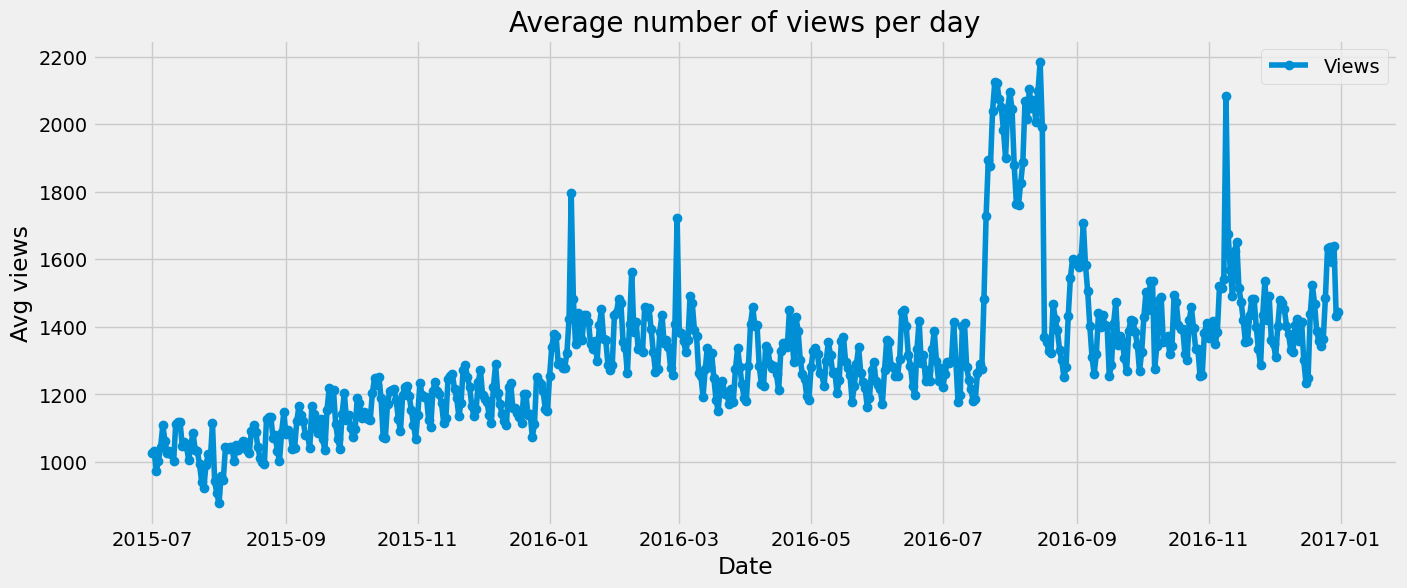

In [7]:
temp = df_reshaped.groupby("Date")['Views'].mean()

plt.figure(figsize=(15, 6))
plt.xlabel('Date')
plt.ylabel('Avg views')
plt.title('Average number of views per day')
plt.plot(temp, marker='o', label='Views')
plt.legend()
plt.show()

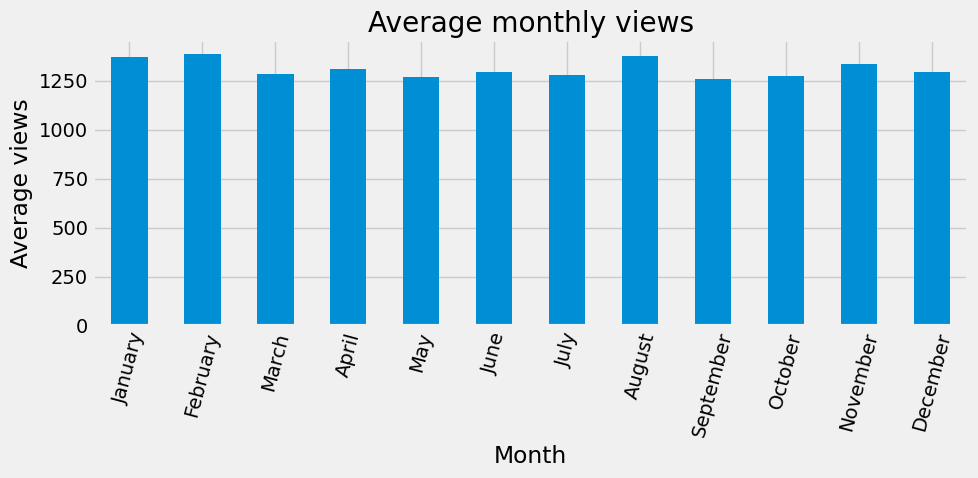

In [8]:
month_index = df_reshaped.index.month
views_by_month = df_reshaped.groupby(month_index)['Views'].mean()
months=['January','February','March','April','May','June','July','August','September','October','November','December']
ax = views_by_month.plot(kind='bar', figsize=(10, 5))

ax.set_xticks(range(len(months)))
ax.set_xticklabels(months, rotation=75)

ax.set_xlabel('Month')
ax.set_ylabel("Average views")
ax.set_title("Average monthly views")

plt.tight_layout()
plt.show()

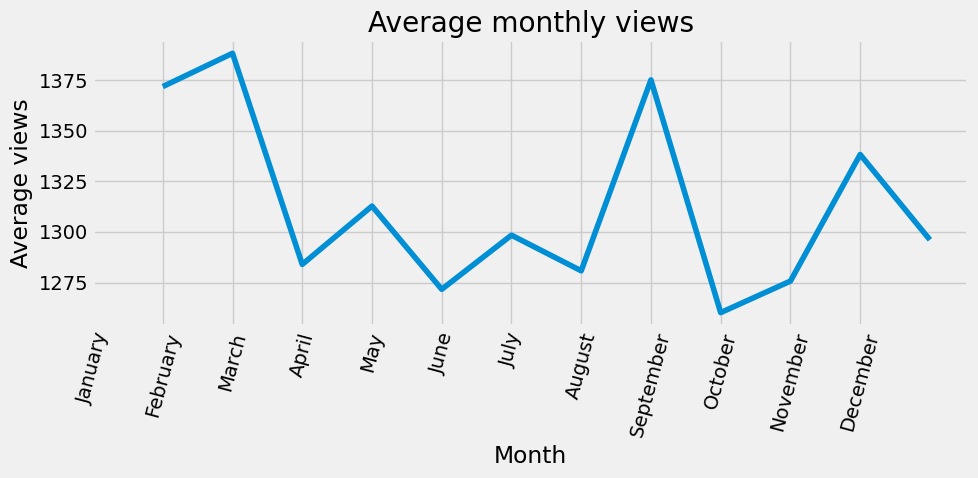

In [9]:
month_index = df_reshaped.index.month
views_by_month = df_reshaped.groupby(month_index)['Views'].mean()
months=['January','February','March','April','May','June','July','August','September','October','November','December']
ax = views_by_month.plot(figsize=(10, 5))

ax.set_xticks(range(len(months)))
ax.set_xticklabels(months, rotation=75)

ax.set_xlabel('Month')
ax.set_ylabel("Average views")
ax.set_title("Average monthly views")

plt.tight_layout()
plt.show()

In [10]:
def detect_lang(page):
    text = page.split('.wikipedia')
    if re.search('[a-z][a-z]', text[0][-2:]):
        return text[0][-2:]
    else:
        return 'none'

temp1 = df_reshaped
temp1['Wikipedia_page'] = temp1.Page.apply(detect_lang)

In [11]:
def lang_code(code):
    if code == 'zh':
        return 'Chinese'
    elif code == 'fr':
        return 'French'
    elif code == 'en':
        return 'English'
    elif code == 'ru':
        return 'Russian'
    elif code == 'de':
        return 'German'
    elif code == 'ja':
        return 'Japanese'
    elif code == 'es':
        return 'Spanish'
    else:
        return 'None'

temp1['Page_language'] = temp1.Wikipedia_page.apply(lang_code)

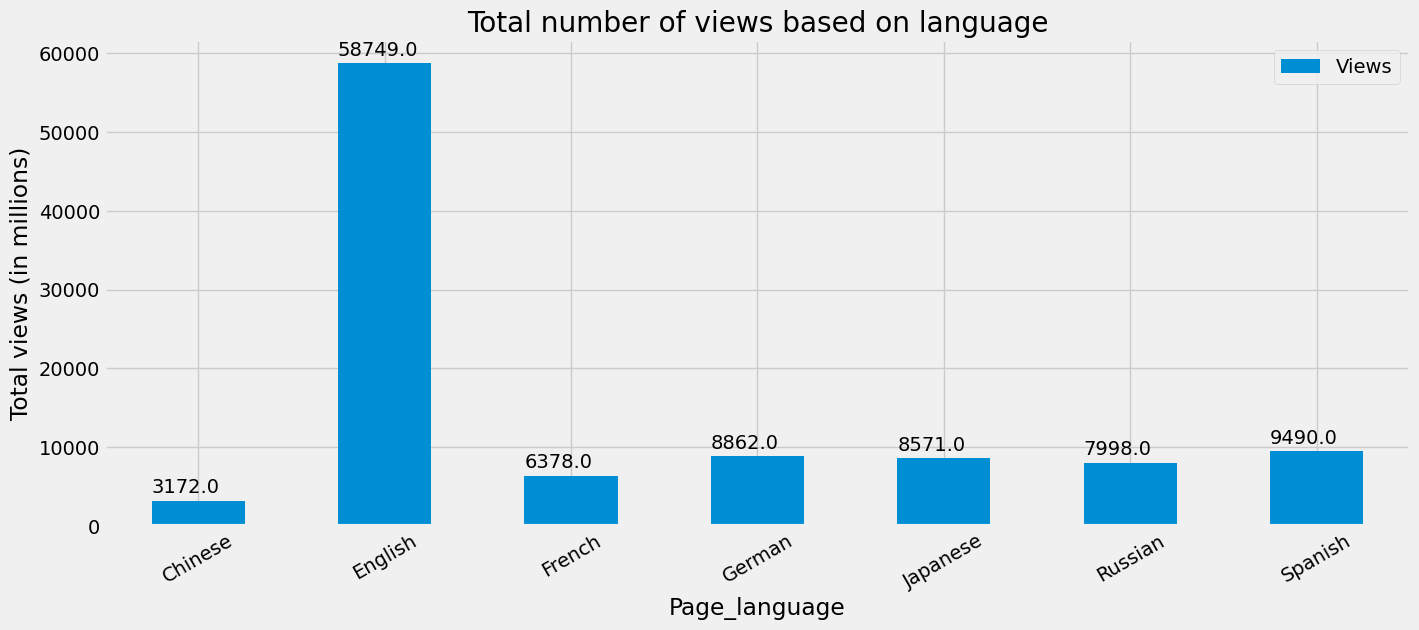

In [12]:
fix, ax = plt.subplots(figsize=(15, 6))
lang_df = temp1.groupby('Page_language')['Views'].sum().reset_index()
lang_df = lang_df[lang_df['Page_language'] != "None"]
lang_df['Views'] = round(lang_df['Views'] / 1000000, 0)

bar_graph = lang_df.plot.bar(x='Page_language', y='Views', rot=30, ax=ax)
bar_graph.set_ylabel('Total views (in millions)')
bar_graph.set_title('Total number of views based on language')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height() + 1000))

ax.legend()
plt.show()

In [13]:
days_df = df_reshaped.copy()

days_df = days_df[['Page', 'Views']]
days_df['Dayofweek'] = days_df.index.dayofweek

In [14]:
def find_day(day):
    if day == 0:
        return 'Monday'
    elif day == 1:
        return 'Tuesday'
    elif day == 2:
        return 'Wednesday'
    elif day == 3:
        return 'Thursday'
    elif day == 4:
        return 'Friday'
    elif day == 5:
        return 'Saturday'
    else:
        return 'Sunday'

days_df['Days'] = days_df.Dayofweek.apply(find_day)

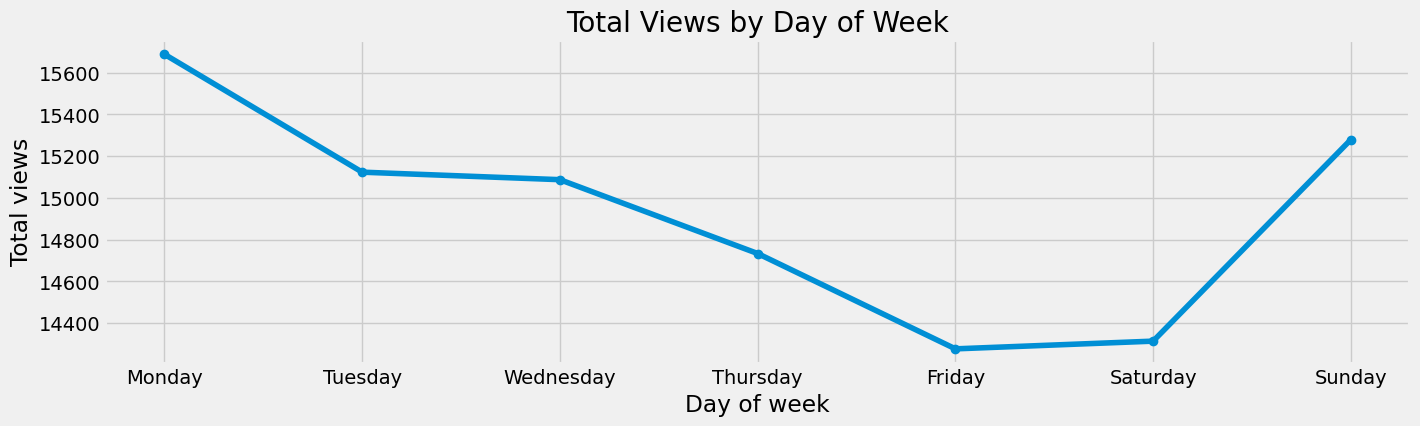

In [15]:
day = days_df.groupby("Days")['Views'].sum()

order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

day = day.reindex(order)
day = (day / 1_000_000).round(0)

plt.figure(figsize=(15, 4))
plt.xlabel('Day of week')
plt.ylabel('Total views')
plt.plot(day, marker='o')
plt.title('Total Views by Day of Week')
plt.show()

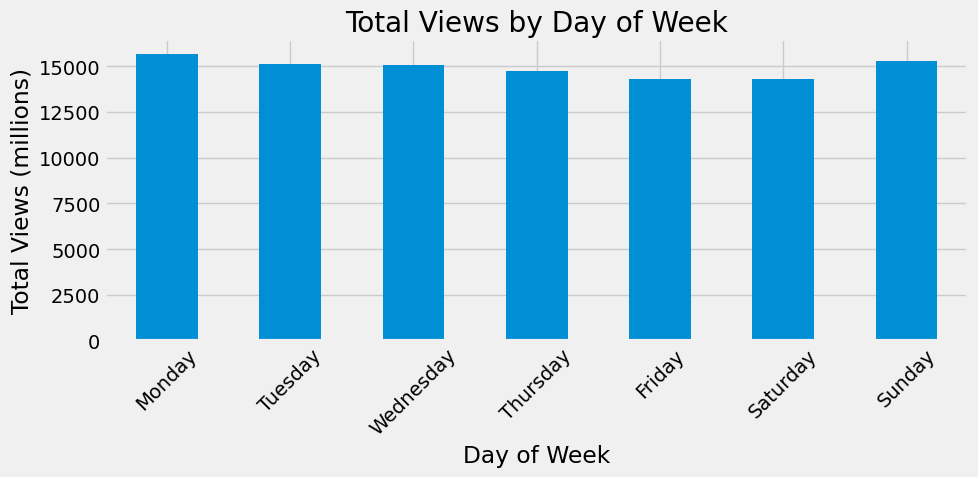

In [16]:
plt.figure(figsize=(10, 5))
ax = day.plot(kind='bar')

ax.set_xlabel("Day of Week")
ax.set_ylabel("Total Views (millions)")
ax.set_title("Total Views by Day of Week")

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [17]:
# top 5 pages

top_pages = df_reshaped.groupby("Page")['Views'].sum().reset_index()
top_pages_list = top_pages.nlargest(5, 'Views')['Page'].tolist()

In [23]:
top_pages_list

['Main_Page_en.wikipedia.org_all-access_all-agents',
 'Main_Page_en.wikipedia.org_desktop_all-agents',
 'Main_Page_en.wikipedia.org_mobile-web_all-agents',
 'Wikipedia:Hauptseite_de.wikipedia.org_all-access_all-agents',
 'Special:Search_en.wikipedia.org_all-access_all-agents']

In [24]:
top5_pages_df = df_reshaped[df_reshaped['Page'].isin(top_pages_list)]

In [25]:
top5_pages_df.head()

Page       Views  \
Date                                                                        
2015-07-01      Main_Page_en.wikipedia.org_desktop_all-agents  11952559.0   
2015-07-01   Main_Page_en.wikipedia.org_all-access_all-agents  20381245.0   
2015-07-01  Special:Search_en.wikipedia.org_all-access_all...   2034850.0   
2015-07-01   Main_Page_en.wikipedia.org_mobile-web_all-agents   8039732.0   
2015-07-01  Wikipedia:Hauptseite_de.wikipedia.org_all-acce...   2983623.0   

           Wikipedia_page Page_language  
Date                                     
2015-07-01             en       English  
2015-07-01             en       English  
2015-07-01             en       English  
2015-07-01             en       English  
2015-07-01             de        German

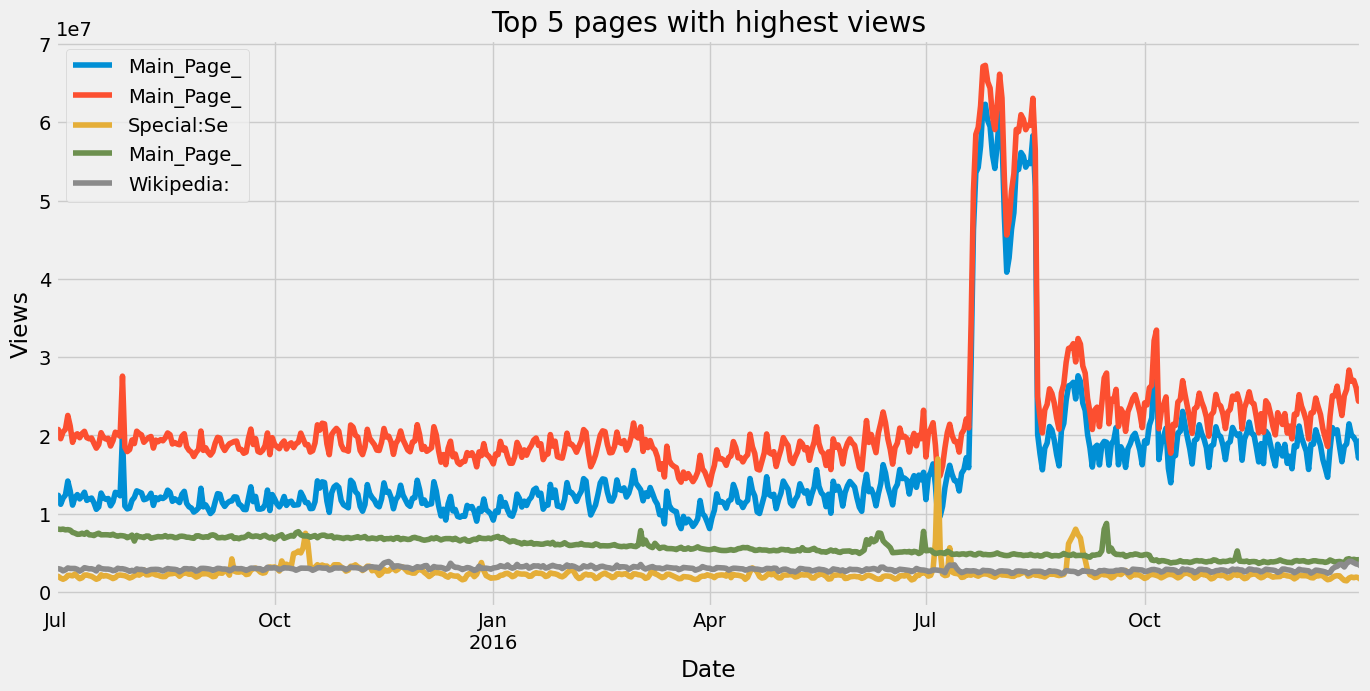

In [27]:
fix, ax = plt.subplots(figsize=(15, 7))
for i in list(top5_pages_df.Page.unique())[:5]:
    top5_pages_df.loc[top5_pages_df.Page == i].plot(ax=ax)

ax.set_ylabel('Views')
ax.legend([name[:10] for name in list(top5_pages_df.Page.unique())[:5]], loc='upper left')
plt.title('Top 5 pages with highest views')
plt.show()

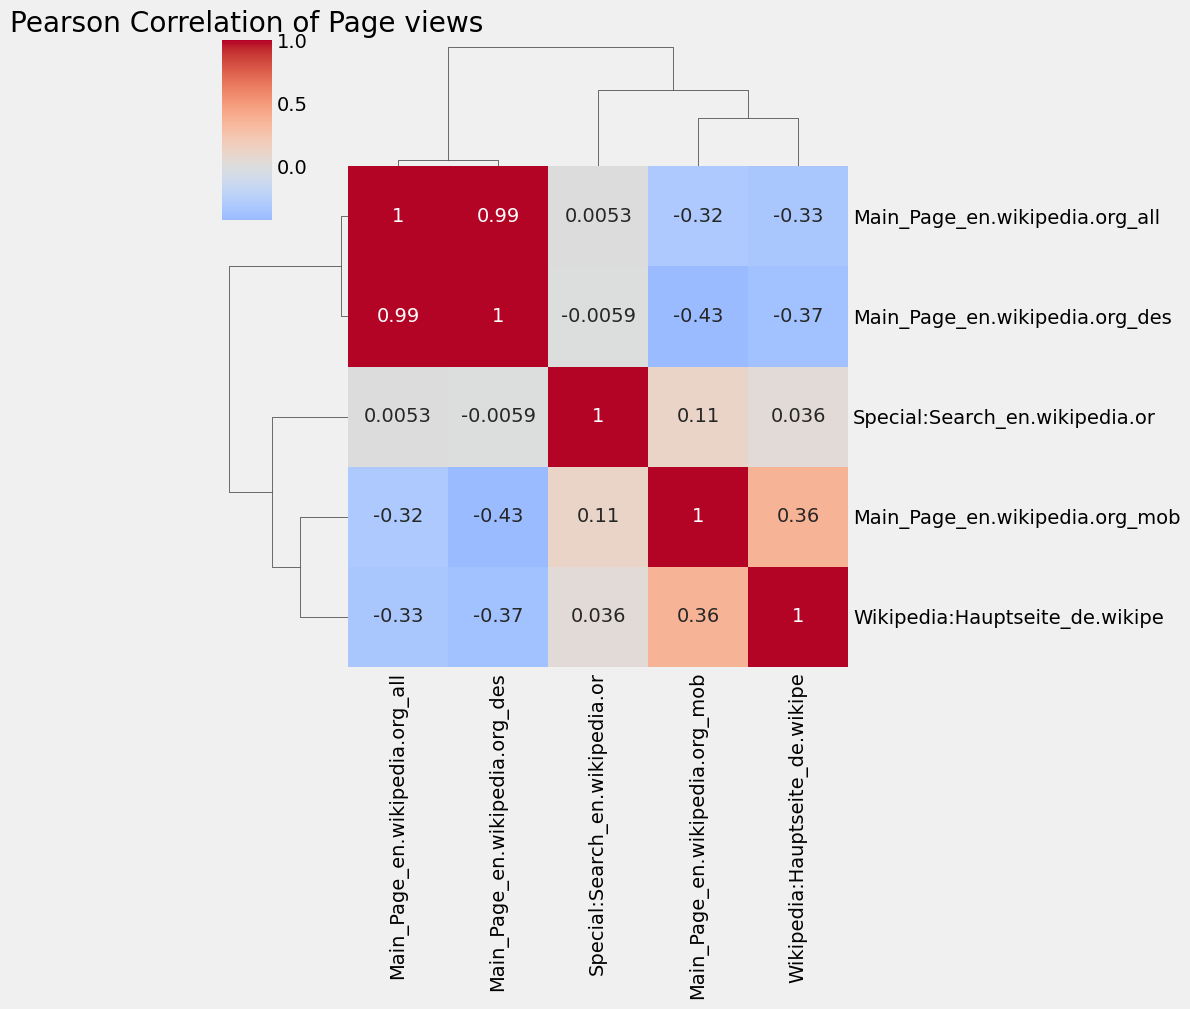

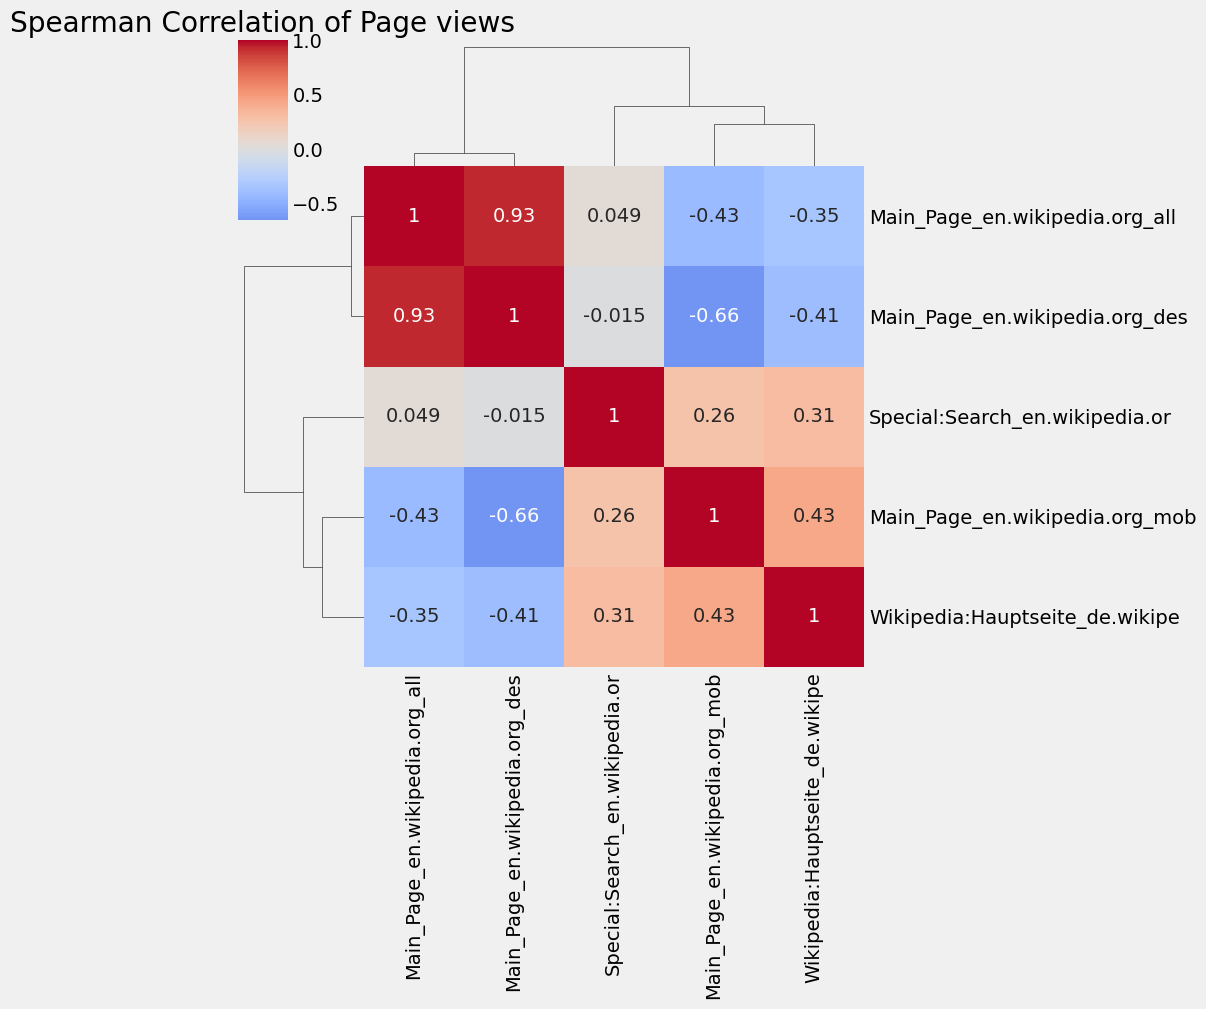

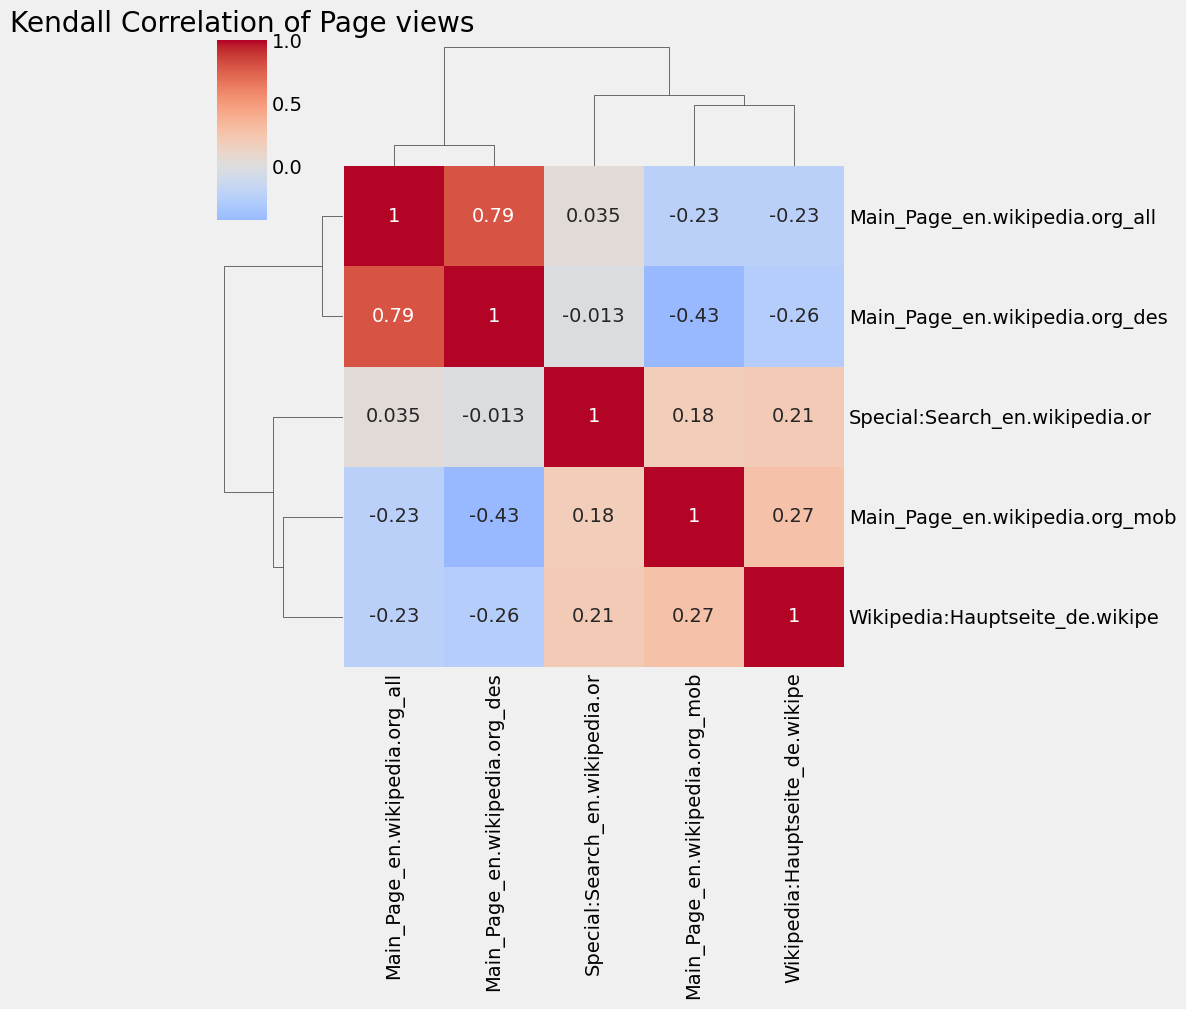

In [28]:
# correlation between pages

table = pd.pivot_table(top5_pages_df, values='Views', index=['Date'], columns=['Page'])

methods = ['pearson', 'spearman', 'kendall']

for method in methods:
    corr_matrix = table.corr(method=method)

    truncated_names = [name[:30] for name in corr_matrix.columns]
    corr_matrix.index = truncated_names
    corr_matrix.columns = truncated_names

    sns.clustermap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title(f"{method.capitalize()} Correlation of Page views")
    plt.show()

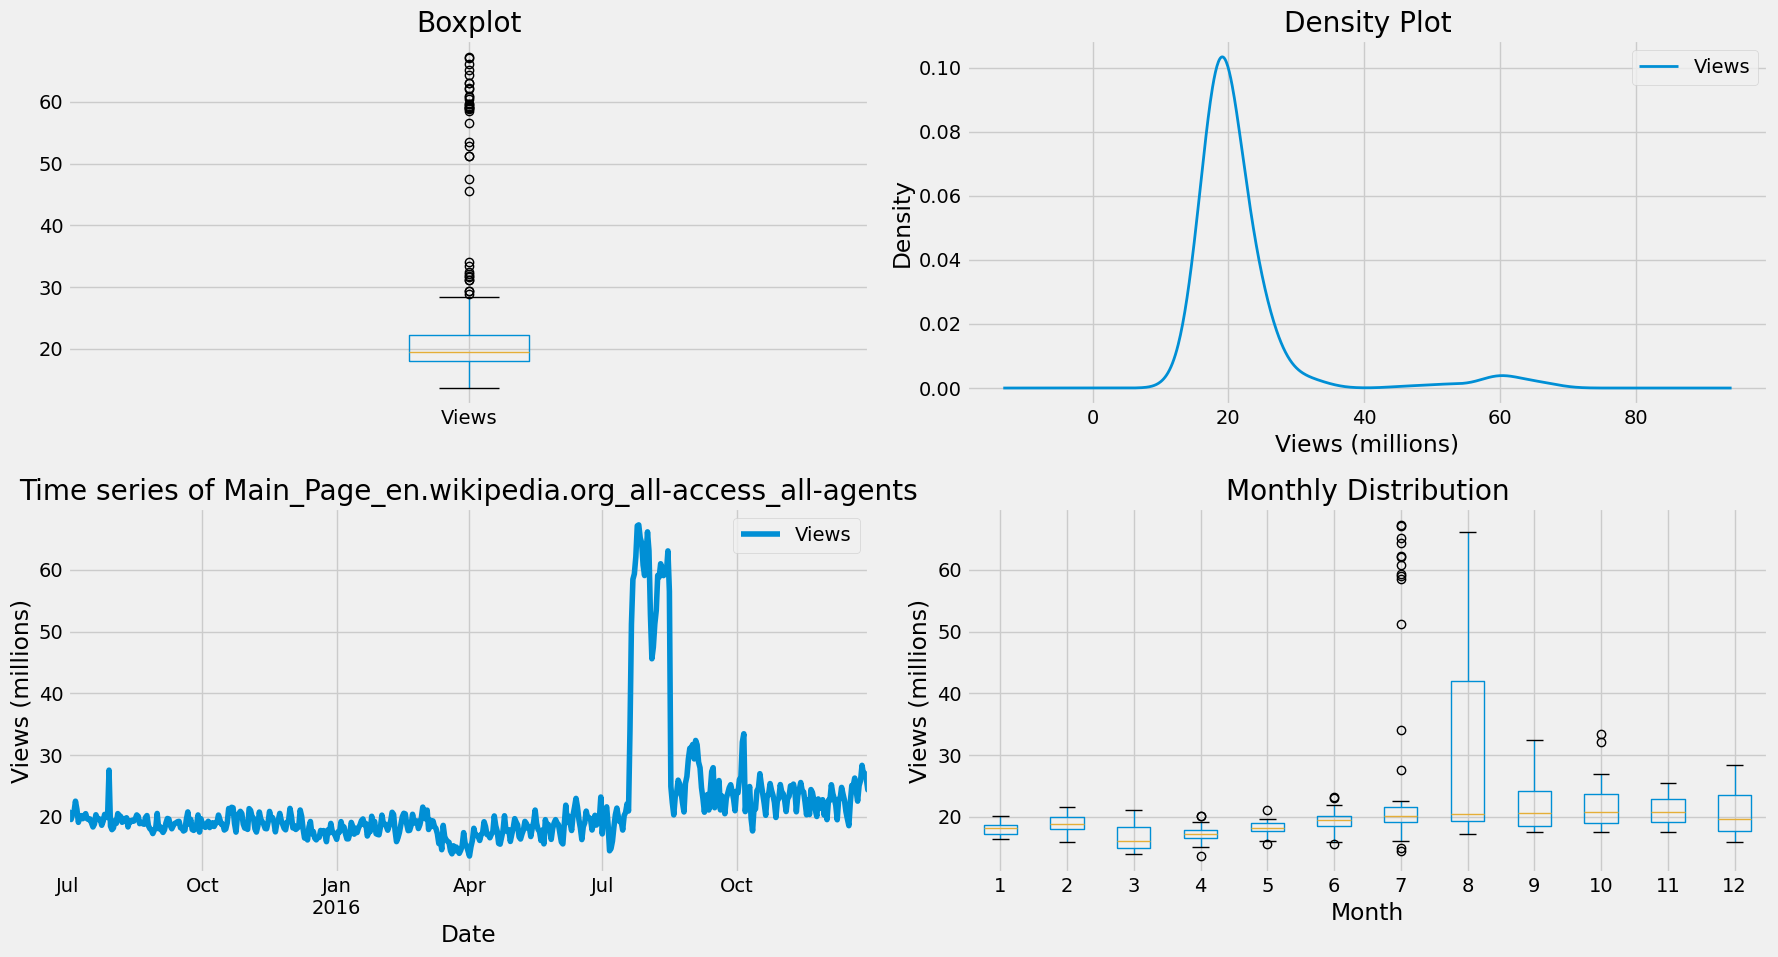

In [29]:
top_page_df = df_reshaped[df_reshaped.Page == top_pages_list[0]]
top_page_df = top_page_df[['Views']]

top_page_df['Views'] = top_page_df['Views'].div(1000000).round(2)

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

top_page_df.boxplot(ax=axes[0][0])
axes[0][0].set_title('Boxplot')

top_page_df.plot(kind='density', linewidth=2, ax=axes[0][1])
axes[0][1].set_xlabel("Views (millions)")
axes[0][1].set_title('Density Plot')

top_page_df.plot(ax=axes[1][0])
axes[1][0].set_ylabel('Views (millions)')
axes[1][0].set_title(f"Time series of {top_pages_list[0]}")

df_monthly = top_page_df.copy()
df_monthly['Month'] = df_monthly.index.month
df_monthly.boxplot(column='Views', by='Month', ax=axes[1][1])
axes[1][1].set_title("Monthly Distribution")
axes[1][1].set_ylabel("Views (millions)")
plt.suptitle("")  # remove default Pandas boxplot title


plt.tight_layout()
plt.show()

In [30]:
top_page_df.head()

Views
Date             
2015-07-01  20.38
2015-07-02  20.75
2015-07-03  19.57
2015-07-04  20.44
2015-07-05  20.77

In [31]:
## Anomaly detection - Isolation forest


isolation_forest_model = IsolationForest(contamination=0.08)
isolation_forest_model.fit(top_page_df)
top_page_df['anomaly'] = isolation_forest_model.predict(top_page_df)

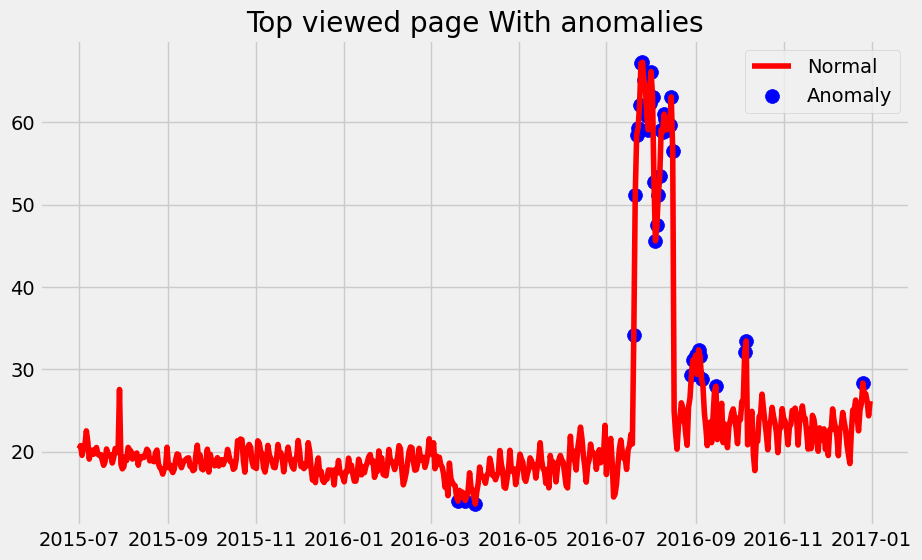

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))

anomaly_df = top_page_df.loc[top_page_df['anomaly'] == -1].copy()
ax.plot(top_page_df.index, top_page_df['Views'], color='red', label='Normal')
plt.scatter(anomaly_df.index, anomaly_df['Views'], color='blue', s=100, label='Anomaly')
plt.title("Top viewed page With anomalies")
plt.legend()
plt.show()

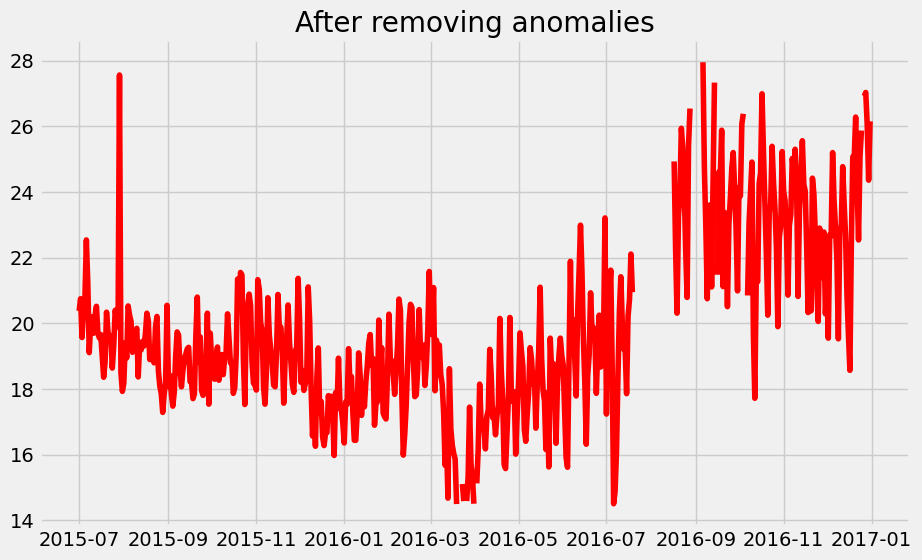

In [38]:
# removing anomalies from the data

top_page_df['new_views'] = top_page_df.apply(lambda row: row.Views if row.anomaly == 1 else None, axis='columns')
plt.figure(figsize=(10, 6))
plt.plot(top_page_df.index, top_page_df.new_views, color='red')
plt.title('After removing anomalies')
plt.show()

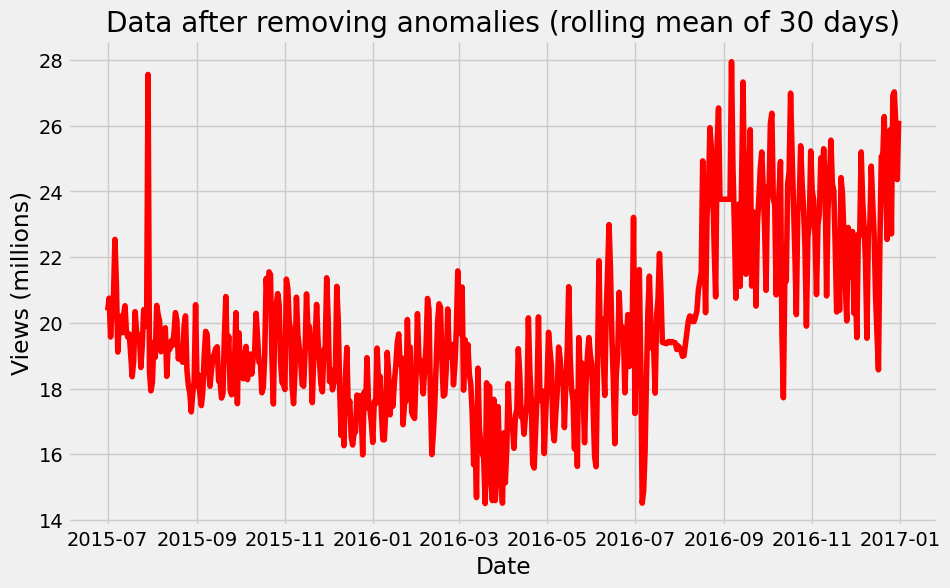

In [43]:
# filling missing values with rolling means

top_page_df = top_page_df.assign(rolling_mean=top_page_df.new_views.fillna(top_page_df.new_views.rolling(30, min_periods=1).mean()))

plt.figure(figsize=(10, 6))
plt.plot(top_page_df.index, top_page_df.rolling_mean, color='red')
plt.title('Data after removing anomalies (rolling mean of 30 days)')
plt.xlabel("Date")
plt.ylabel("Views (millions)")
plt.show()

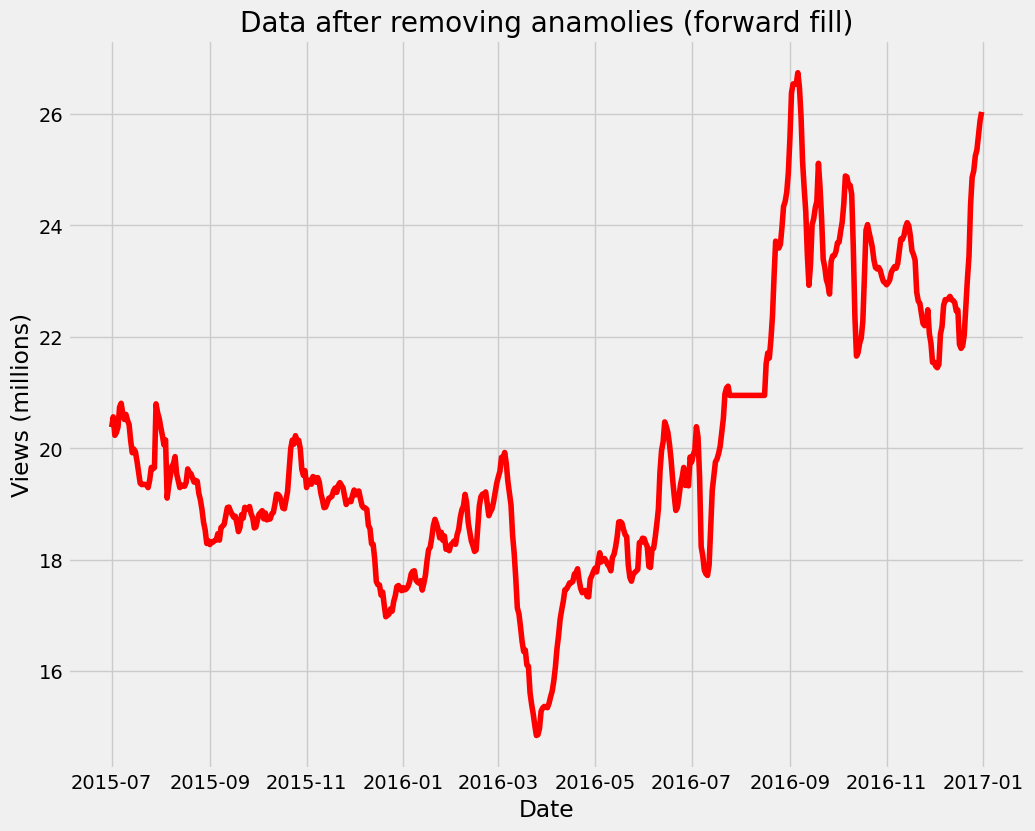

In [27]:
top_page_df = top_page_df.assign(
    rolling_mean = top_page_df.new_views
        .fillna(method="ffill")   # forward fill first
        # .fillna(method="bfill")   
        .rolling(7, min_periods=1).mean()
)

plt.figure(figsize=(11, 9))
plt.plot(top_page_df.index, top_page_df.rolling_mean, color='red')
plt.title('Data after removing anamolies (forward fill)')
plt.xlabel("Date")
plt.ylabel("Views (millions)")
plt.show()

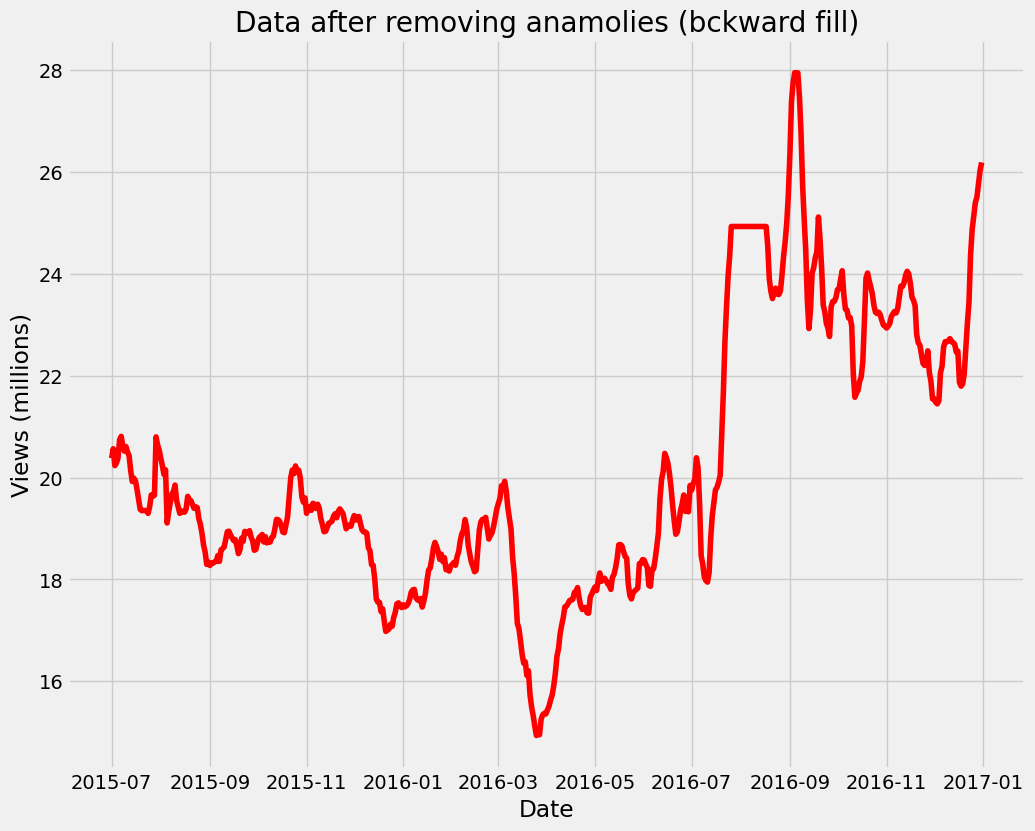

In [28]:
top_page_df = top_page_df.assign(
    rolling_mean = top_page_df.new_views
        # .fillna(method="ffill")   
        .fillna(method="bfill")   
        .rolling(7, min_periods=1).mean()
)

plt.figure(figsize=(11, 9))
plt.plot(top_page_df.index, top_page_df.rolling_mean,color='red')
plt.title('Data after removing anamolies (bckward fill)')
plt.xlabel("Date")
plt.ylabel("Views (millions)")
plt.show()

In [44]:
top_page_df.head()

Views  anomaly  new_views  rolling_mean
Date                                               
2015-07-01  20.38        1      20.38         20.38
2015-07-02  20.75        1      20.75         20.75
2015-07-03  19.57        1      19.57         19.57
2015-07-04  20.44        1      20.44         20.44
2015-07-05  20.77        1      20.77         20.77

In [45]:
top_page_df_tmp = top_page_df.drop(columns=['Views', 'anomaly', 'new_views']).rename(columns={'rolling_mean' : 'Views'})

In [46]:
top_page_df = top_page_df_tmp.copy()

In [47]:
top_page_df.head()

Views
Date             
2015-07-01  20.38
2015-07-02  20.75
2015-07-03  19.57
2015-07-04  20.44
2015-07-05  20.77

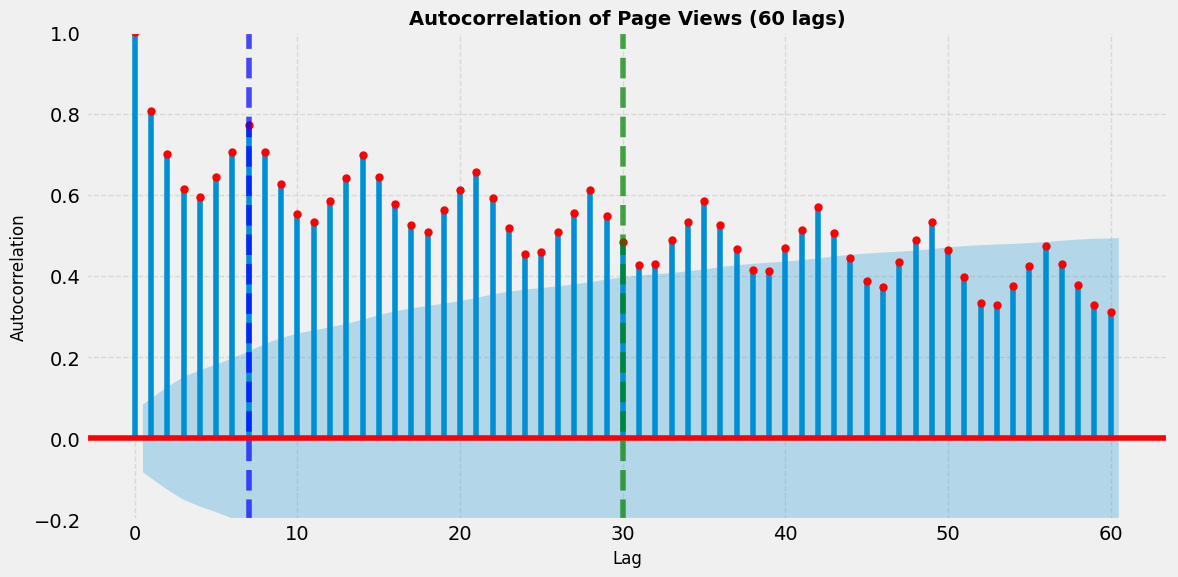

In [48]:
fig, ax = plt.subplots(figsize=(12, 6))

tsaplots.plot_acf(
    top_page_df['Views'], 
    lags=60, 
    ax=ax, 
    color='red',  
    alpha=0.05    
)
ax.set_title("Autocorrelation of Page Views (60 lags)", fontsize=14, fontweight="bold")
ax.set_xlabel("Lag", fontsize=12)
ax.set_ylabel("Autocorrelation", fontsize=12)

ax.grid(True, linestyle='--', alpha=0.6)

ax.set_ylim(-0.2, 1.0)

ax.axvline(x=7, color='blue', linestyle='--', alpha=0.7)
ax.axvline(x=30, color='green', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

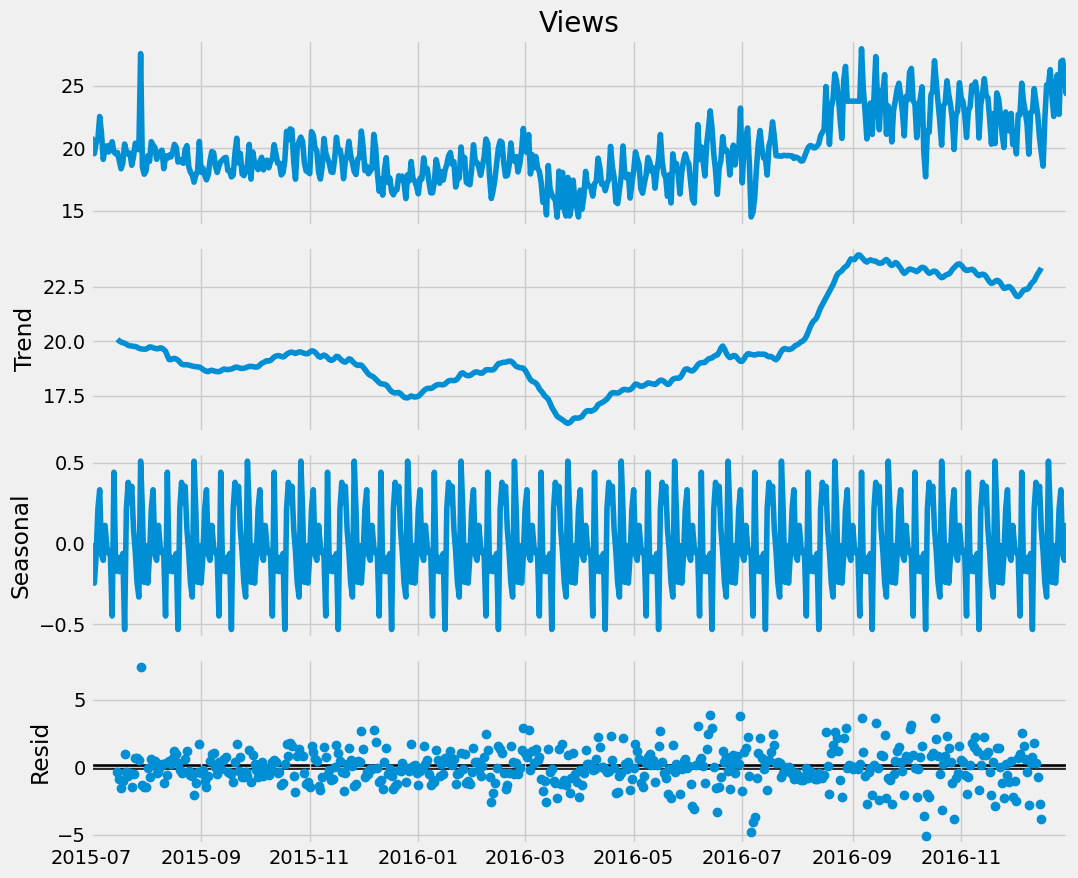

In [49]:
rcParams['figure.figsize'] = 11, 9

ts_decomposition = sm.tsa.seasonal_decompose(top_page_df.Views, period=30)
figure = ts_decomposition.plot()

In [50]:
# Test both models
additive_result = sm.tsa.seasonal_decompose(top_page_df.Views, model='additive', period=30)
multiplicative_result = sm.tsa.seasonal_decompose(top_page_df.Views, model='multiplicative', period=30)


In [51]:
# Compare the residuals - smaller residuals indicate better fit
print("Additive residuals std:", additive_result.resid.std())
print("Multiplicative residuals std:", multiplicative_result.resid.std())

Additive residuals std: 1.3593910320230773
Multiplicative residuals std: 0.06747867113180565


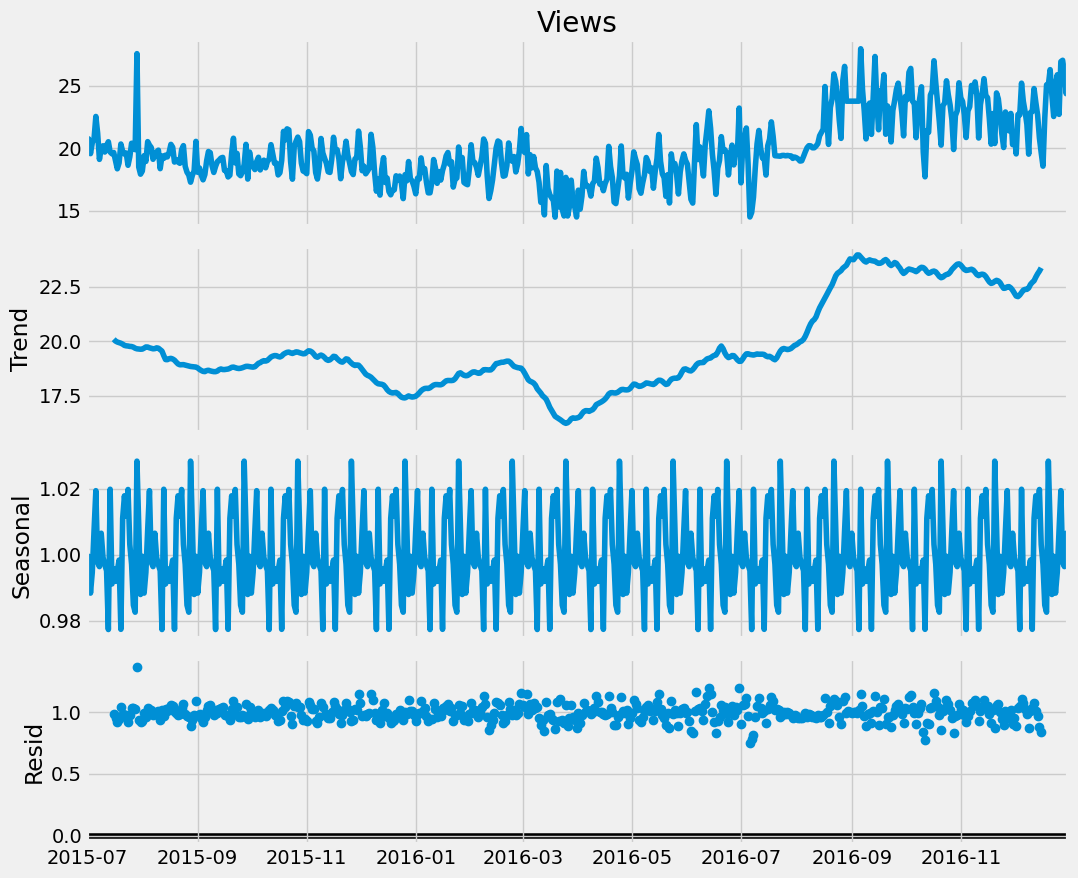

In [52]:
rcParams['figure.figsize'] = 11, 9

ts_decomposition = sm.tsa.seasonal_decompose(top_page_df.Views, 
                                             model='multiplicative',
                                             period=30)
figure = ts_decomposition.plot()

In [53]:
## Augumented dicky fuller test

test = adfuller(top_page_df['Views'])
print(test)

(-0.4834120816293958, 0.8952130708964574, 14, 535, {'1%': -3.4426321555520905, '5%': -2.86695748394138, '10%': -2.5696553279762426}, 1776.7031116708565)


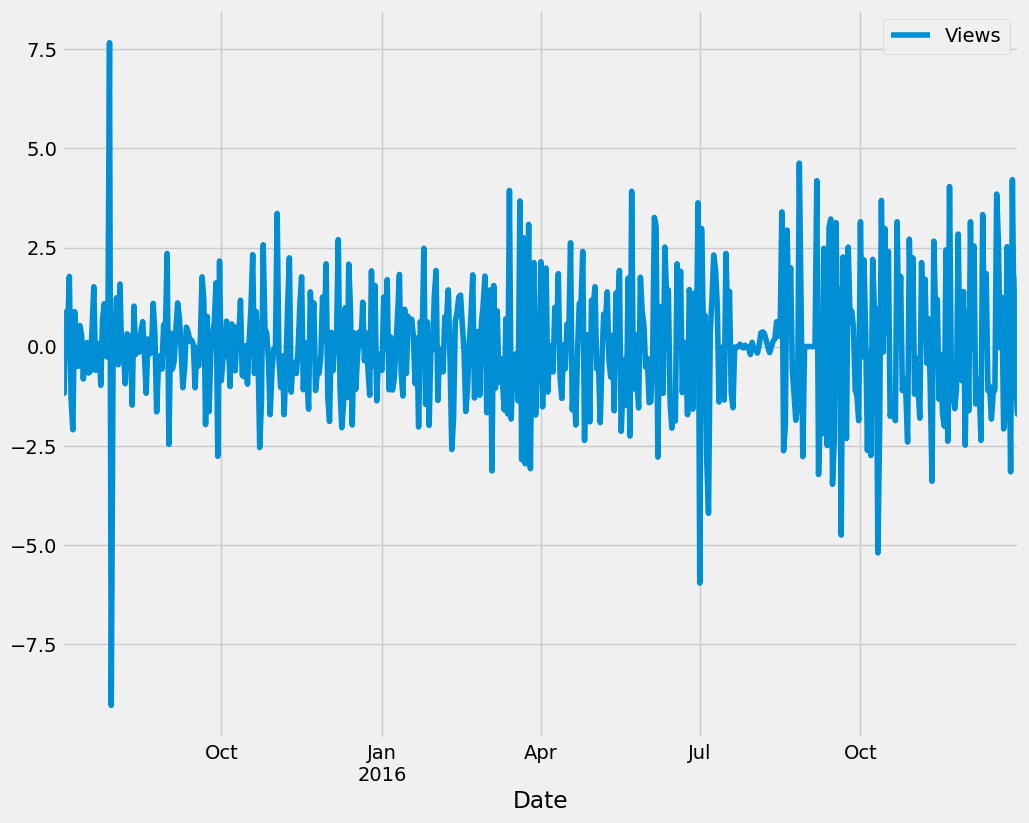

In [54]:
# -0.497 ADF score data is non-stationary

top_page_stationary_df = top_page_df.diff().dropna()
ax = top_page_stationary_df.plot()

In [63]:
top_page_df.head()

Views
Date             
2015-07-01  20.38
2015-07-02  20.75
2015-07-03  19.57
2015-07-04  20.44
2015-07-05  20.77

In [64]:
top_page_stationary_df.head()

Views
Date             
2015-07-02   0.37
2015-07-03  -1.18
2015-07-04   0.87
2015-07-05   0.33
2015-07-06   1.77

In [55]:
test2 = adfuller(top_page_stationary_df['Views'])
print(test2)

(-8.17042956569431, 8.65235663500211e-13, 13, 535, {'1%': -3.4426321555520905, '5%': -2.86695748394138, '10%': -2.5696553279762426}, 1772.6235241503562)


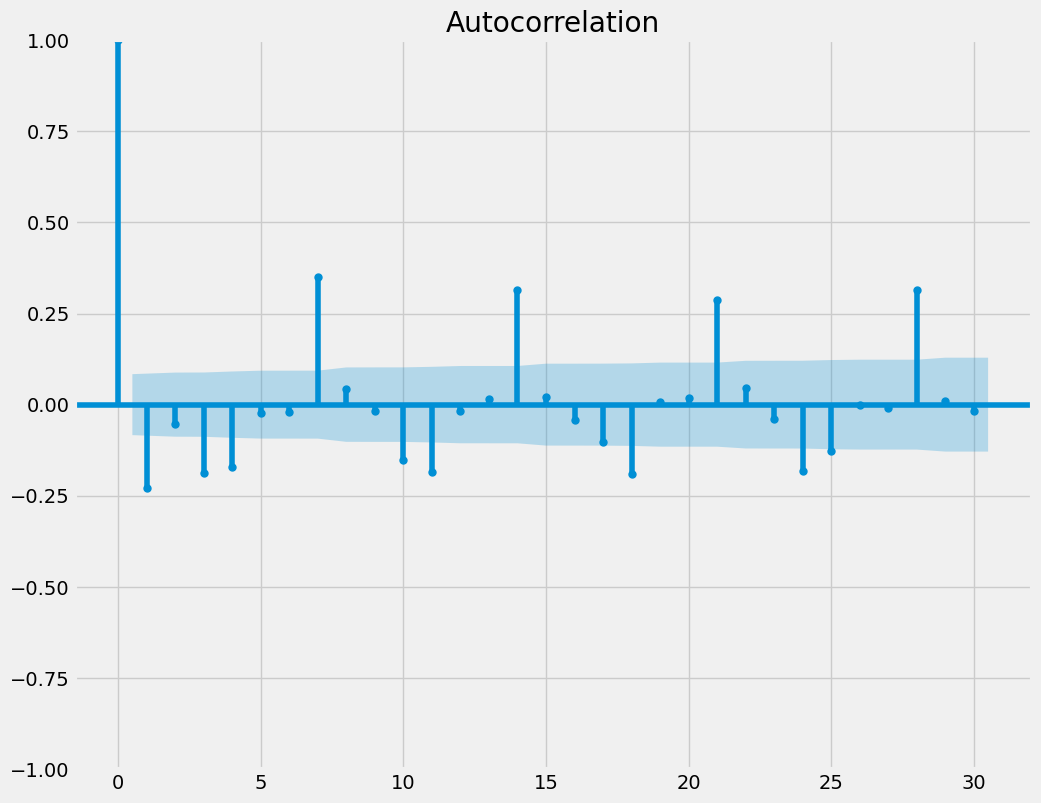

In [56]:
fig = tsaplots.plot_acf(top_page_stationary_df['Views'], lags=30)
plt.show()

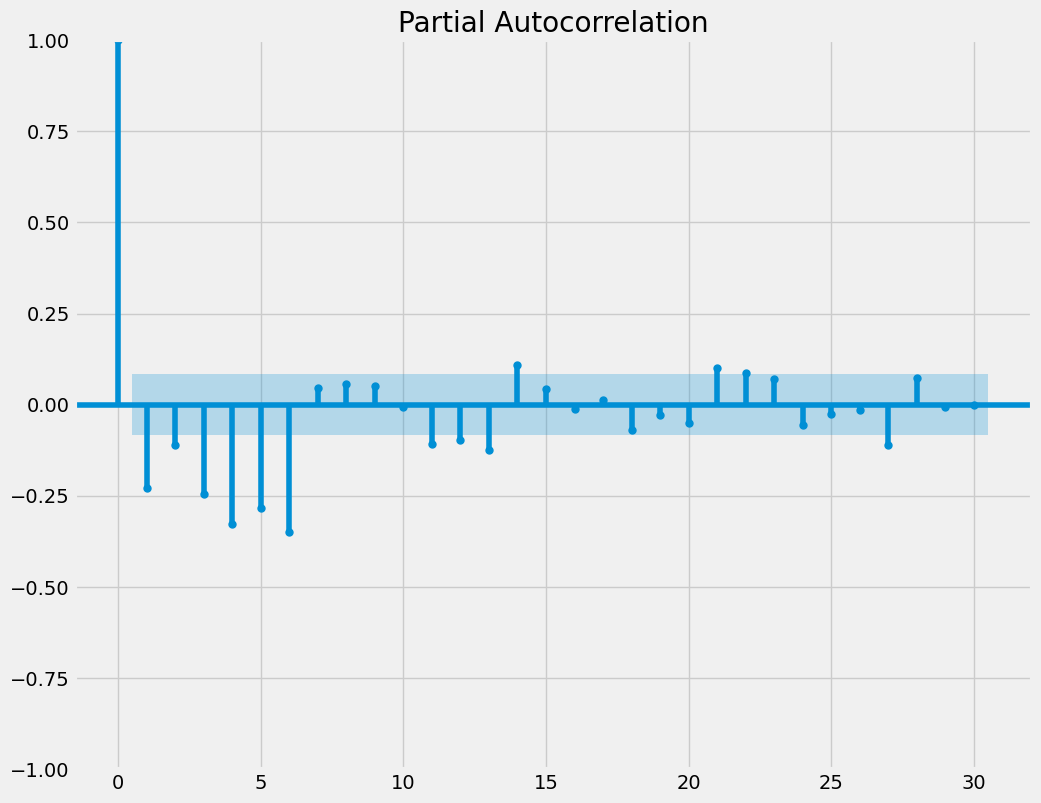

In [57]:
fig = tsaplots.plot_pacf(top_page_stationary_df['Views'], lags=30)
plt.show()

In [58]:
train = top_page_df[:'2016-09']
test = top_page_df['2016-10':]

train.shape, test.shape

((458, 1), (92, 1))

In [21]:
train = pd.read_csv('train.csv', index_col=0, parse_dates=True)
test = pd.read_csv('test.csv', index_col=0, parse_dates=True)

In [59]:
train.head()

Views
Date             
2015-07-01  20.38
2015-07-02  20.75
2015-07-03  19.57
2015-07-04  20.44
2015-07-05  20.77

In [65]:
test.tail()

Views
Date             
2016-12-27  26.92
2016-12-28  27.03
2016-12-29  26.07
2016-12-30  24.36
2016-12-31  26.15

In [46]:
train.to_csv("train.csv", index=True)
test.to_csv('test.csv', index=True)

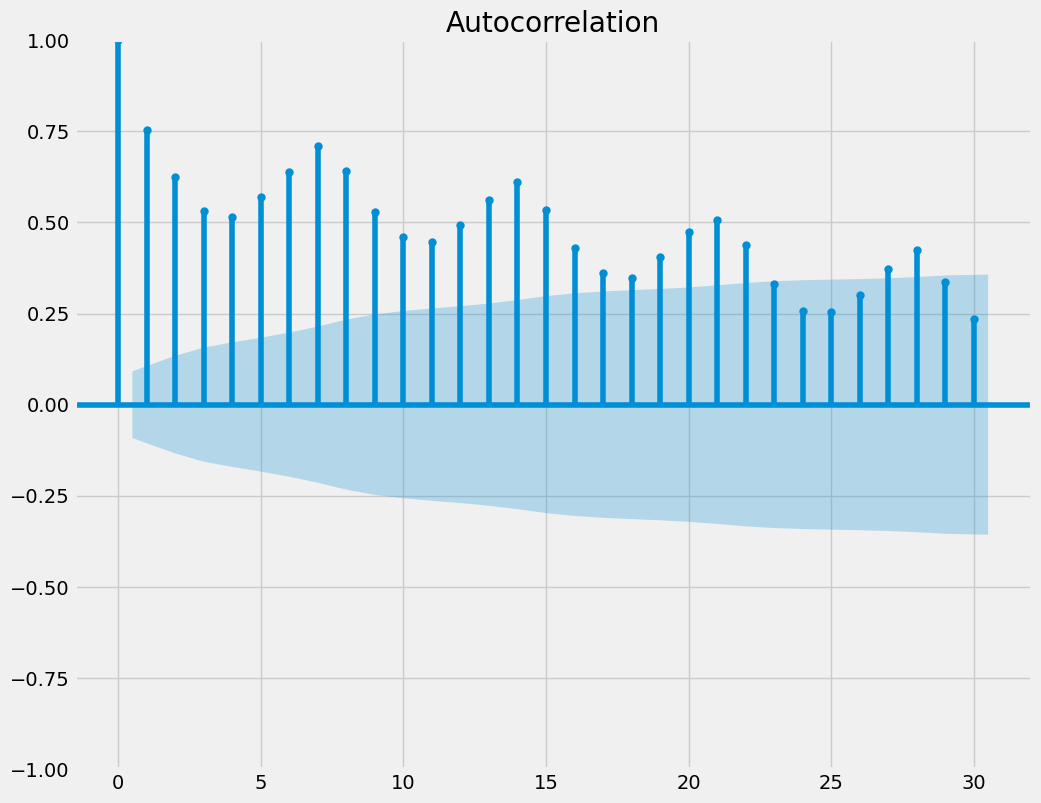

In [61]:
fig = tsaplots.plot_acf(train['Views'], lags=30)
plt.show()

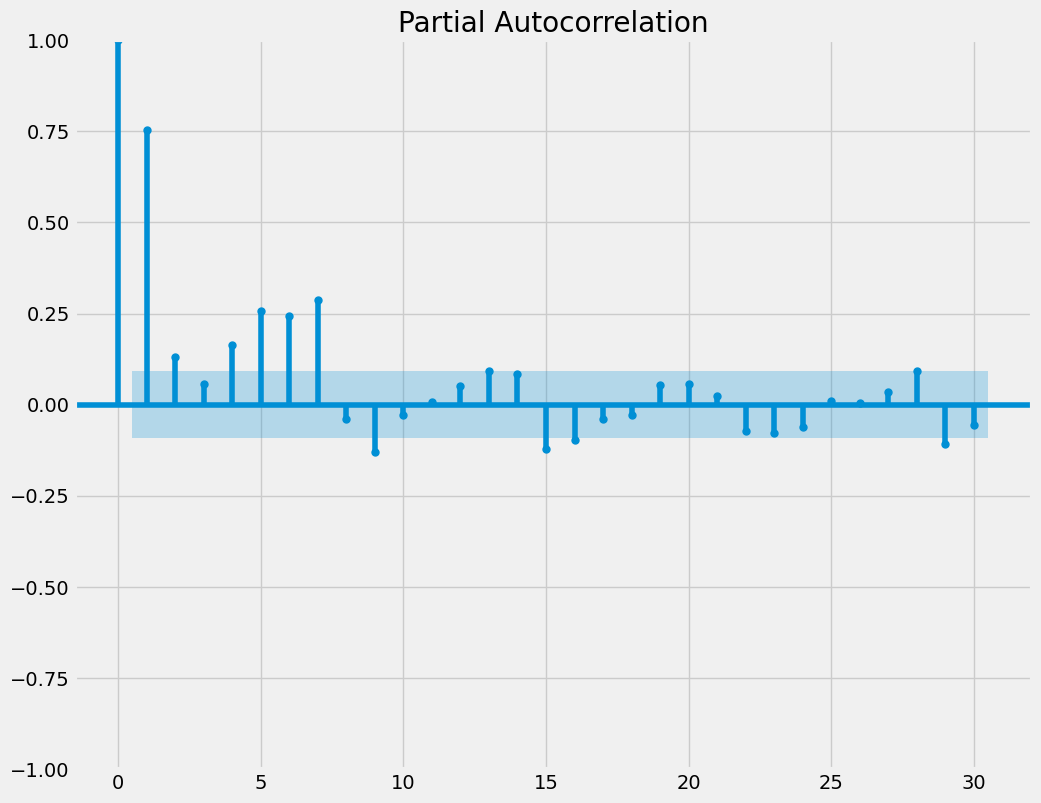

In [66]:
fig = tsaplots.plot_pacf(train['Views'], lags=30)
plt.show()

## Modelling

### ARMA

In [81]:
aic_bic_values = []

for p in range(7):
    for q in range(7):
        try:
            model = SARIMAX(train, order=(p, 0, q))
            results = model.fit()
            aic_bic_values.append((p, q, results.aic, results.bic))
        except:
            continue

In [82]:
aic_bic_df = pd.DataFrame(aic_bic_values, columns=['p', 'q', 'aic', 'bic'])
aic_bic_df = aic_bic_df.sort_values(by=['aic', 'bic'])

In [83]:
aic_bic_df.head()

p  q          aic          bic
30  4  2    33.369262    62.257347
25  3  4  1471.064082  1504.079035
33  4  5  1486.640387  1527.909079
48  6  6  1488.305158  1541.954458
46  6  4  1491.769077  1537.164638

In [84]:
model = SARIMAX(train, order=(int(aic_bic_df.iloc[0]['p']), 0, int(aic_bic_df.iloc[0]['q'])))
arma_result = model.fit()

In [ ]:
with open('model/arma_model.pkl', 'wb') as f:
    pickle.dump(arma_result, f)

In [86]:
with open('model/arma_model.pkl', 'rb') as f:
    arma_loaded = pickle.load(f)

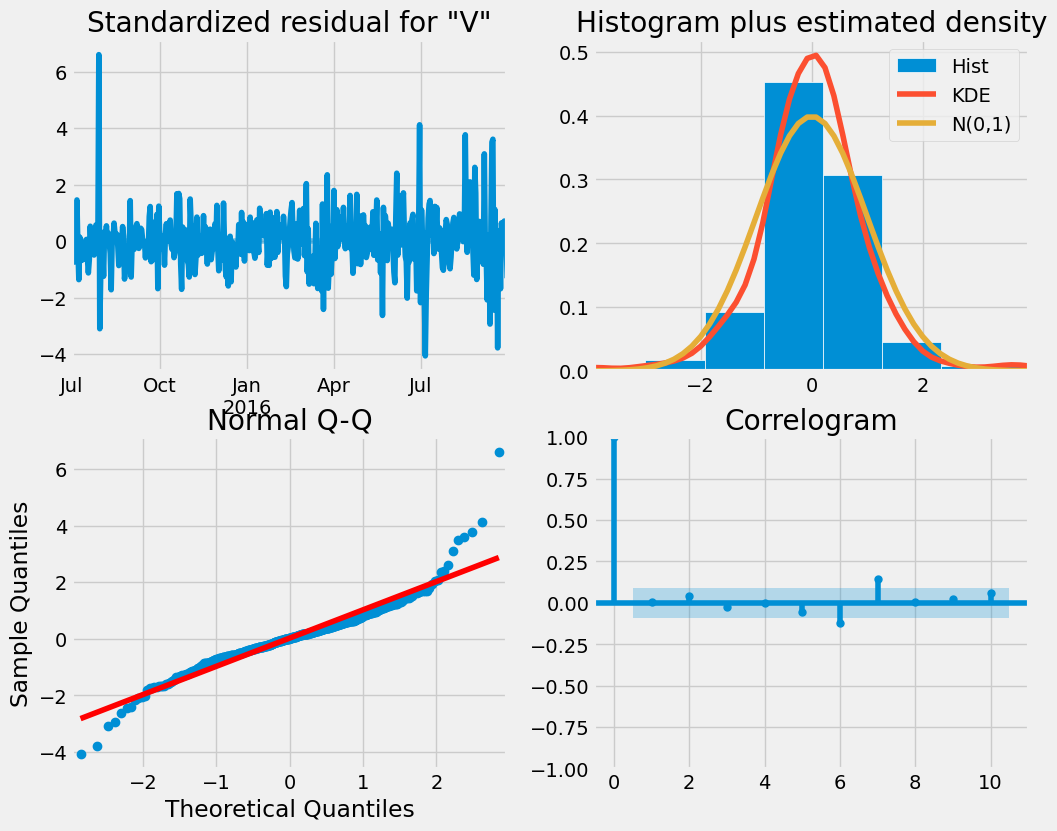

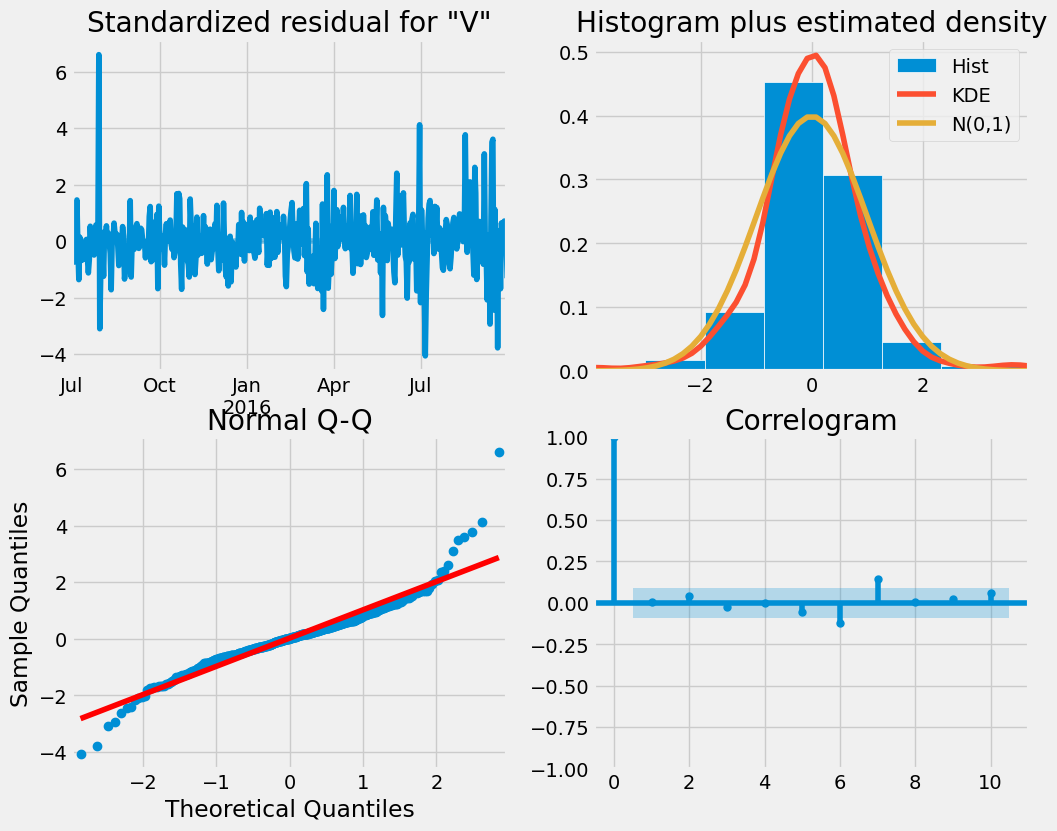

In [88]:
arma_loaded.plot_diagnostics()

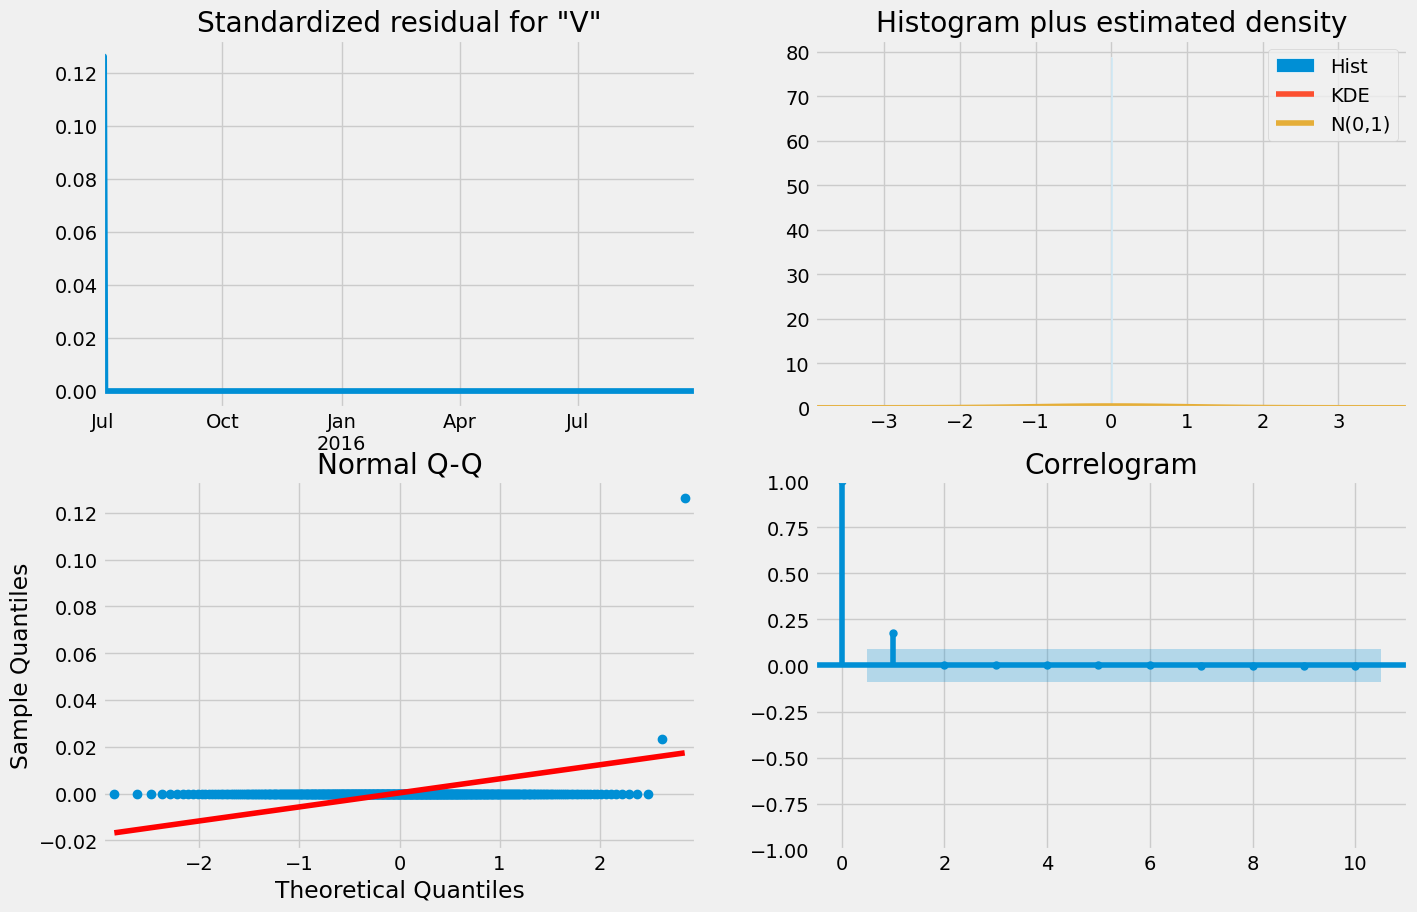

In [85]:
arma_result.plot_diagnostics(figsize=(15, 10))
plt.show()

In [89]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Views   No. Observations:                  458
Model:               SARIMAX(3, 0, 4)   Log Likelihood                -725.975
Date:                Fri, 05 Sep 2025   AIC                           1467.950
Time:                        23:00:37   BIC                           1500.965
Sample:                    07-01-2015   HQIC                          1480.953
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.2462      0.003    795.411      0.000       2.241       2.252
ar.L2         -2.2451      0.005   -485.965      0.000      -2.254      -2.236
ar.L3          0.9989      0.003    384.258      0.000       0.994       1.004
ma.L1         -1.8696      0.033    -56.137      0.000      -1.935      -1.804
ma.L2          1.6243      0.066     24.624      0.000       1.495       1.754
ma.L3         -0.4389      0.065     -6.719      0.000      -0.567      -0.311
ma.L4         -0.1338      0.035     -3.775      0.000      -0.203      -0.064
sigma2         1.3370      0.051     26.028      0.000       1.236       1.438
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               773.69
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.78   Skew:                             0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
forecast = result.get_prediction(start=-30)
forecast_mean = forecast.predicted_mean
confidence_interval = forecast.conf_int()

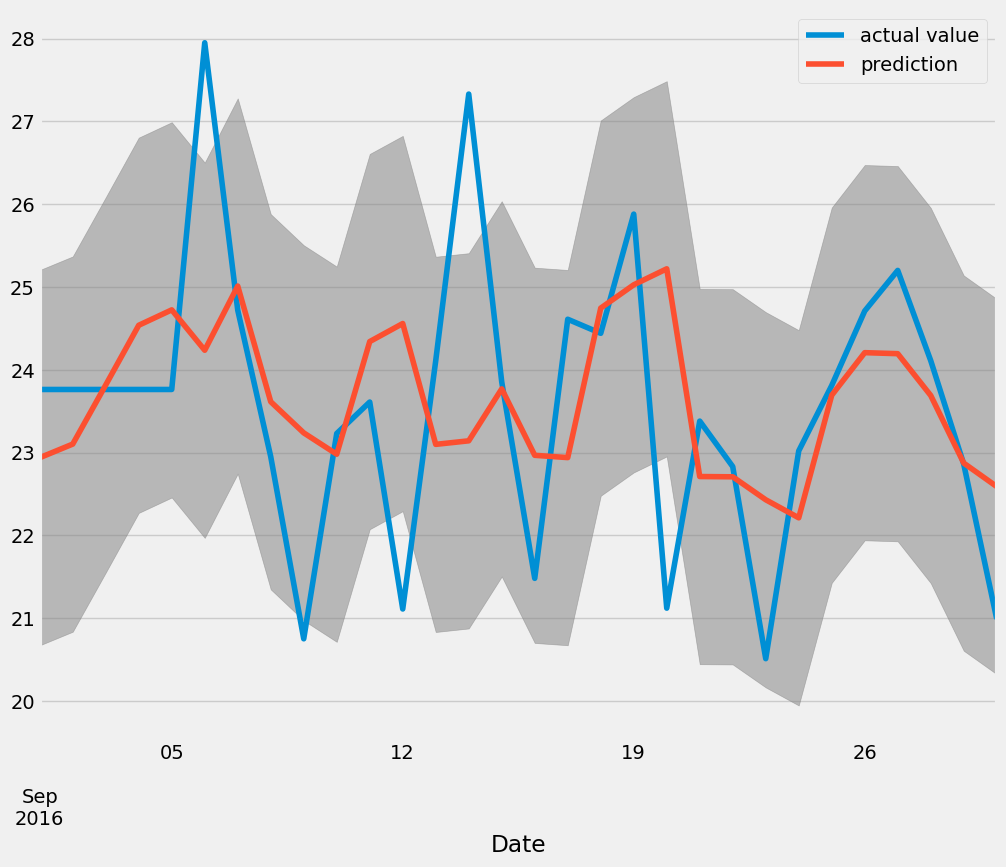

In [82]:
fig, ax = plt.subplots()
train[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
forecast_mean.plot(ax=ax, label='prediction')
plt.fill_between(confidence_interval.index,
                 confidence_interval['lower Views'],
                 confidence_interval['upper Views'],
                 color='grey', alpha=0.5)

plt.legend()
plt.show()

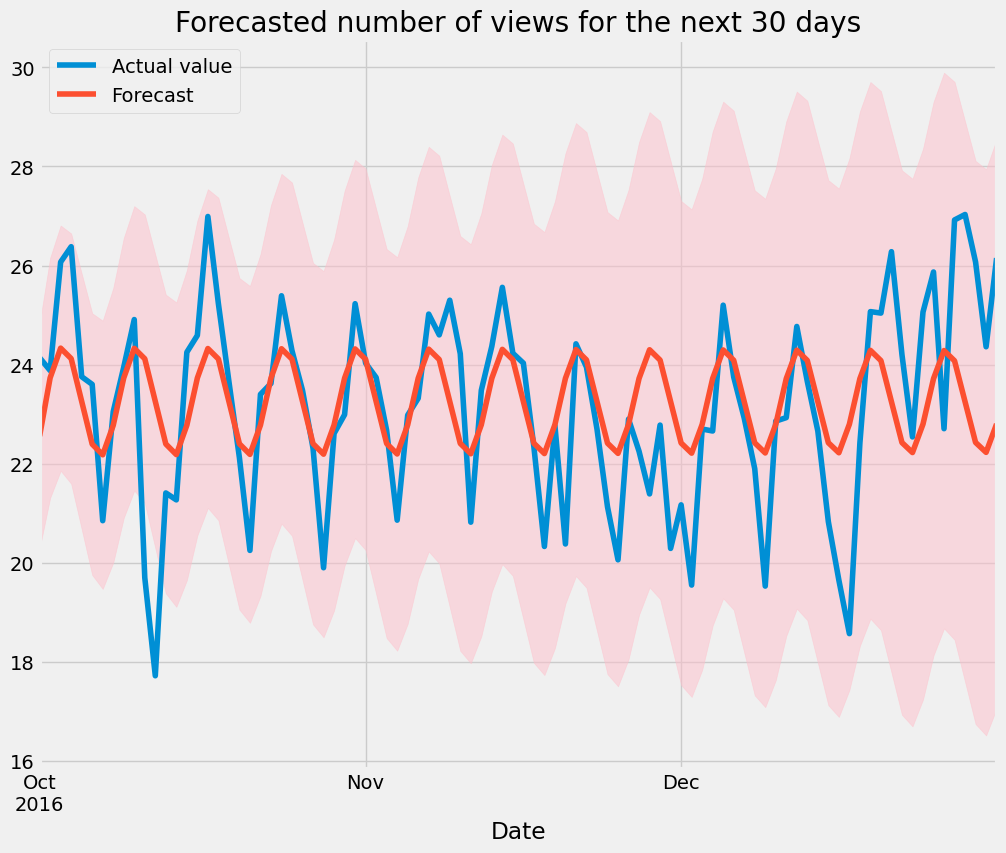

In [ ]:
forecast_values = result.get_forecast(steps=test.shape[0])
forecast_values_mean = forecast_values.predicted_mean
conf_interval = forecast_values.conf_int()

arma_forecast_df = pd.DataFrame({'Date':test.index,'Views':forecast_values.predicted_mean,'lower_views':conf_interval['lower Views'].values,'upper_views':conf_interval['upper Views'].values})
arma_forecast_df = arma_forecast_df.set_index('Date')

fig,ax=plt.subplots()
test.rename(columns={'Views':'Actual value'}).plot(ax=ax)
arma_forecast_df[['Views']].rename(columns={'Views':'Forecast'}).plot(ax=ax,label='Forecast')
plt.fill_between(arma_forecast_df.index, \
                arma_forecast_df.lower_views, \
                arma_forecast_df.upper_views, \
                color='grey', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

In [65]:
rmse_values = []
# rmse_values.append(('ARMA',np.sqrt(np.mean(np.square(forecast_values_mean.values - test.Views.values)))))
rmse_values.append(('ARMA', np.float64(1.725872070858196)))
rmse_values

[('ARMA', 1.725872070858196)]

In [ ]:
result

### ARIMA model

In [32]:
arima_aic_bic = []

for p in range(7):
    for q in range(7):
        try:
            arima_model = SARIMAX(train, order=(p, 1, q))
            arima_results = arima_model.fit()
            arima_aic_bic.append((p, q, arima_results.aic, arima_results.bic))
        except:
            continue
    
arima_aic_bic_df = pd.DataFrame(arima_aic_bic, columns=['p', 'q', 'aic', 'bic'])
arima_aic_bic_df = arima_aic_bic_df.sort_values(by=['aic', 'bic'])

In [33]:
arima_aic_bic_df.head()

p  q          aic          bic
24  3  3  1469.765330  1498.638114
34  4  6  1470.201872  1515.573389
18  2  4  1470.667246  1499.540030
19  2  5  1471.620151  1504.617618
40  5  5  1471.782605  1517.154122

In [34]:
arima_model = SARIMAX(train, order=(int(arima_aic_bic_df.iloc[0]['p']), 1, int(arima_aic_bic_df.iloc[0]['q'])))
arima_results = arima_model.fit()
arima_forecast_mean = arima_results.get_prediction(steps=-30).predicted_mean

In [35]:
with open('model/arima_model.pkl', 'wb') as f:
    pickle.dump(arima_results, f)

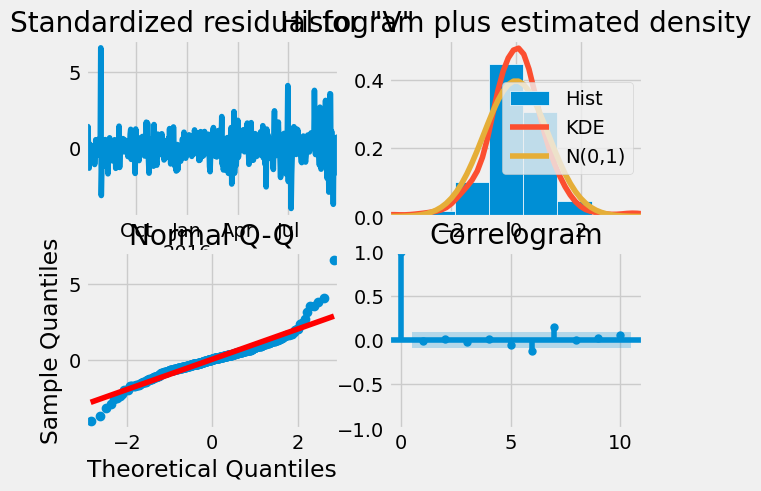

In [36]:
arima_results.plot_diagnostics()
plt.show()

In [82]:
forecast = arima_results.get_prediction(start=-30)
forecast_mean = forecast.predicted_mean
confidence_interval = forecast.conf_int()

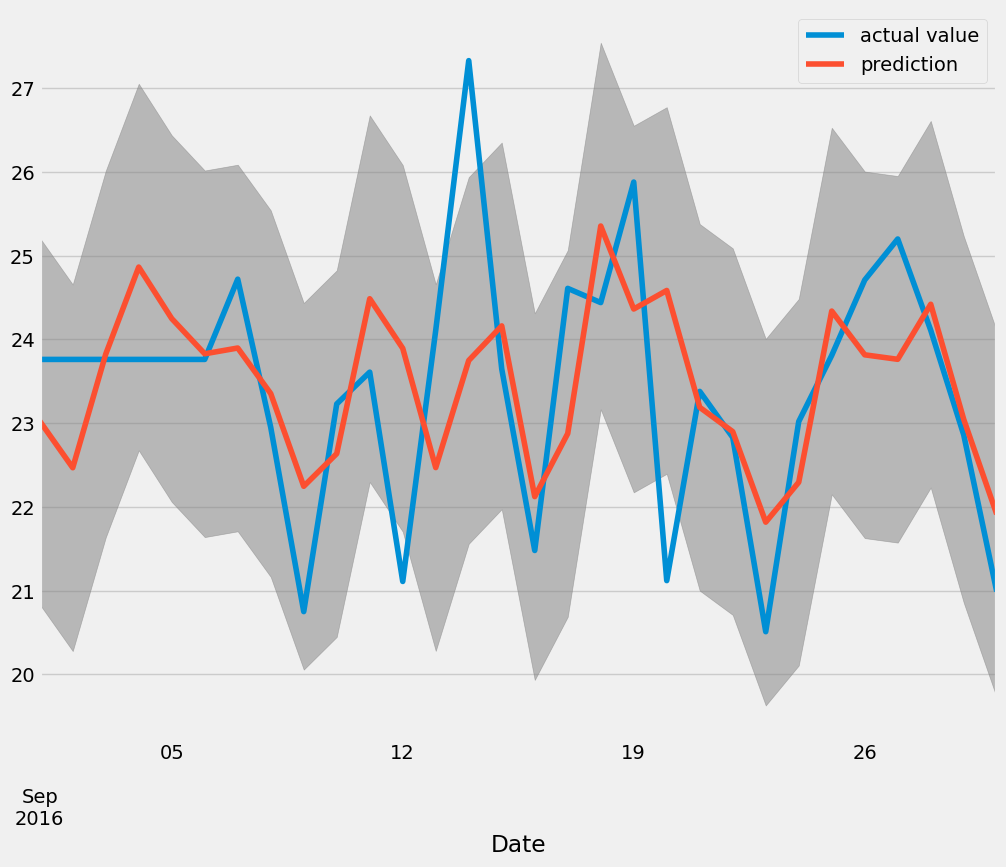

In [84]:
fig, ax = plt.subplots()
train[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
forecast_mean[-30:].plot(ax=ax, label='prediction')
plt.fill_between(confidence_interval.index,
                 confidence_interval['lower Views'],
                 confidence_interval['upper Views'],
                 color='grey', alpha=0.5)

plt.legend()
plt.show()

In [88]:
arima_forecast_values = arima_results.get_forecast(steps=test.shape[0])
arima_forecast_mean = arima_forecast_values.predicted_mean
arima_conf_interval = arima_forecast_values.conf_int()

arima_forecast_df = pd.DataFrame({'Date':test.index, 'Views':arima_forecast_mean, 'lower_views': arima_conf_interval['lower Views'].values, 'upper_views': arima_conf_interval['upper Views'].values})
arima_forecast_df = arima_forecast_df.set_index('Date')

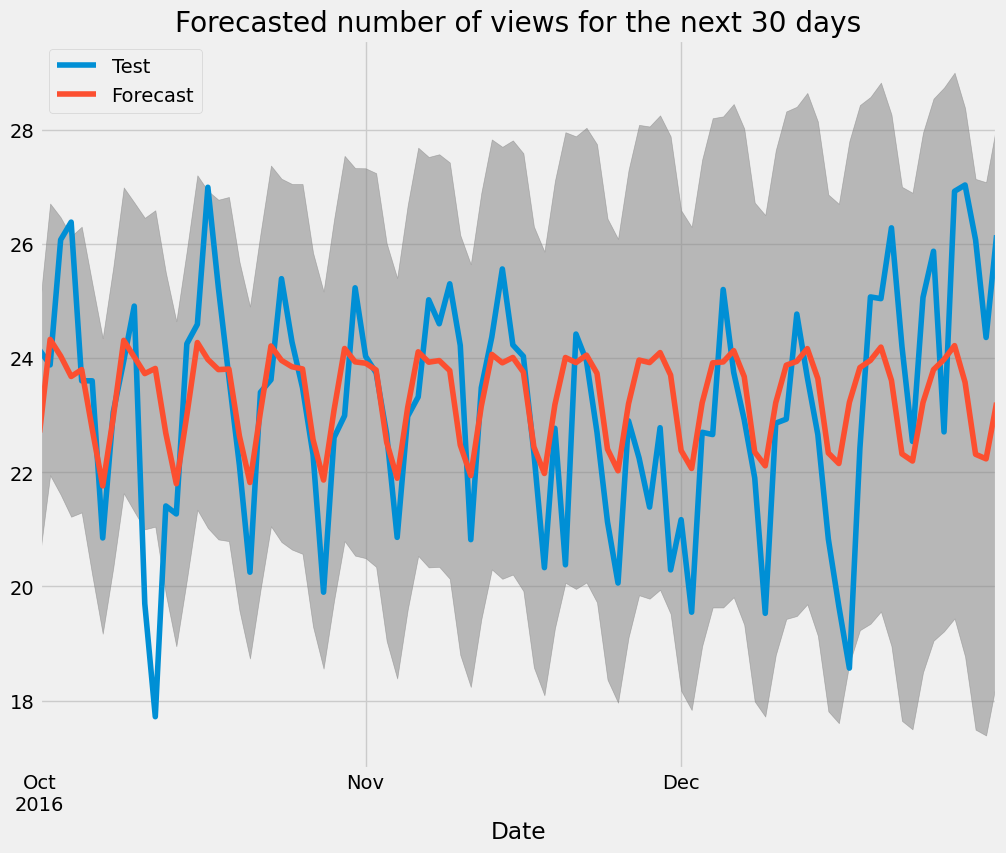

In [90]:
fig, ax = plt.subplots()
test.rename(columns={'Views':'Test'}).plot(ax=ax)
arima_forecast_df[['Views']].rename(columns={'Views':'Forecast'}).plot(ax=ax)
plt.fill_between(arima_forecast_df.index, 
                arima_forecast_df.lower_views, 
                arima_forecast_df.upper_views, 
                color='grey', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

In [66]:
# rmse_values.append(("ARIMA", np.sqrt(np.mean(np.square(arima_forecast_df.Views.values - test.Views.values)))))
rmse_values.append(('ARIMA', np.float64(1.7391178556385445)))
rmse_values

[('ARMA', 1.725872070858196), ('ARIMA', 1.7391178556385445)]

### Exponential Smoothing model

In [37]:
exp_smoothing_model = SimpleExpSmoothing(train)
exp_smoothing_result = exp_smoothing_model.fit(smoothing_level=0.5, optimized=True)

exp_smoothing_prediction = exp_smoothing_result.predict(start=train[-30:-29].index[0], end=train[-1:].index[0])


In [38]:
with open('model/simple_exp_smoothing.pkl', 'wb') as f:
    pickle.dump(exp_smoothing_result, f)

In [39]:
# holt' linear (double exp smoothing)
holt_model = ExponentialSmoothing(train, trend='add', seasonal=None)
holt_result = holt_model.fit()
holt_pred = holt_result.predict(start=train[-30:-29].index[0], end=train[-1:].index[0])

In [40]:
with open('model/holt_add.pkl', 'wb') as f:
    pickle.dump(holt_result, f)

In [41]:
# holt winters (triple exp smoothing)
hw_model = ExponentialSmoothing(
    train, trend='add', seasonal='add',
    seasonal_periods=30
)
hw_result = hw_model.fit()

hw_pred = hw_result.predict(start=train[-30:-29].index[0], end=train[-1:].index[0])

In [42]:
with open('model/holt_add_seasonal.pkl', 'wb') as f:
    pickle.dump(hw_result, f)

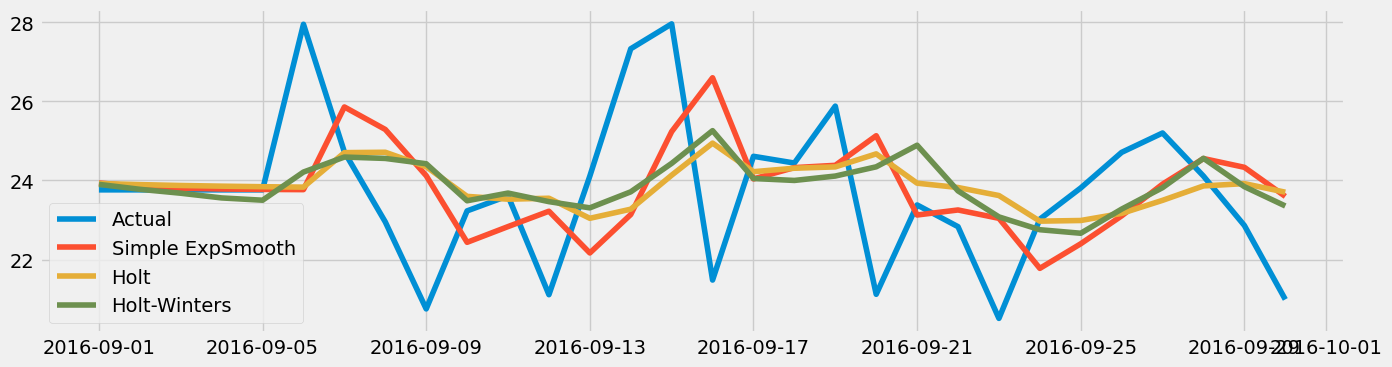

In [43]:
plt.figure(figsize=(15, 4))
plt.plot(train[-30:], label='Actual')
plt.plot(exp_smoothing_prediction, label='Simple ExpSmooth')
plt.plot(holt_pred, label='Holt')
plt.plot(hw_pred, label='Holt-Winters')
plt.legend()
plt.show()

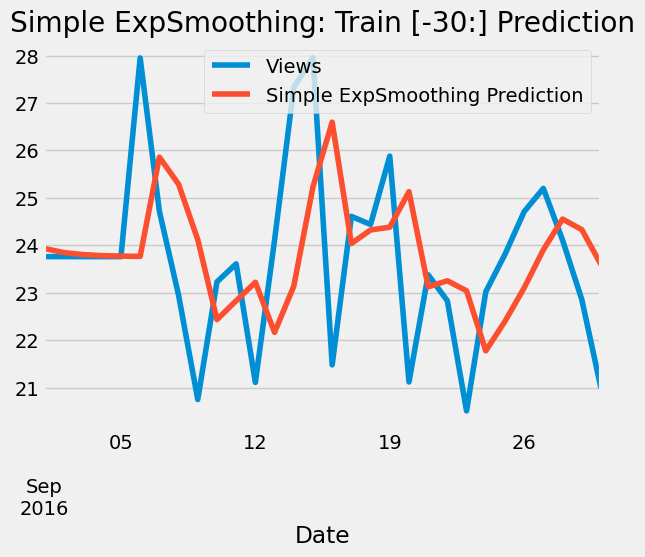

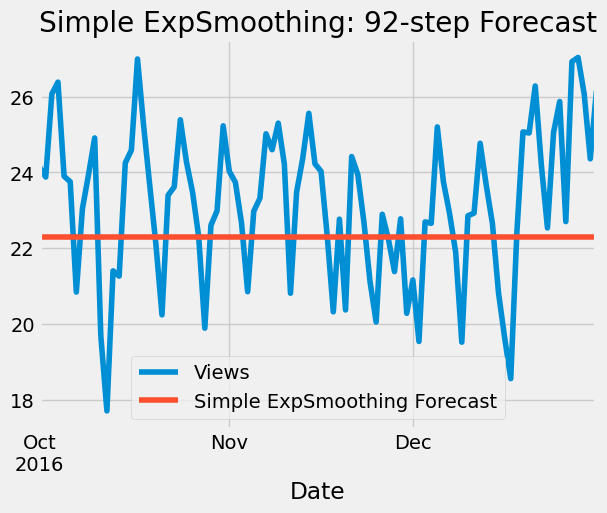

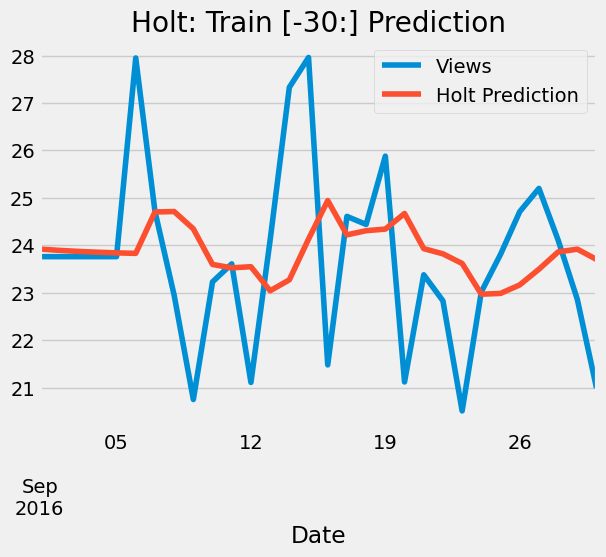

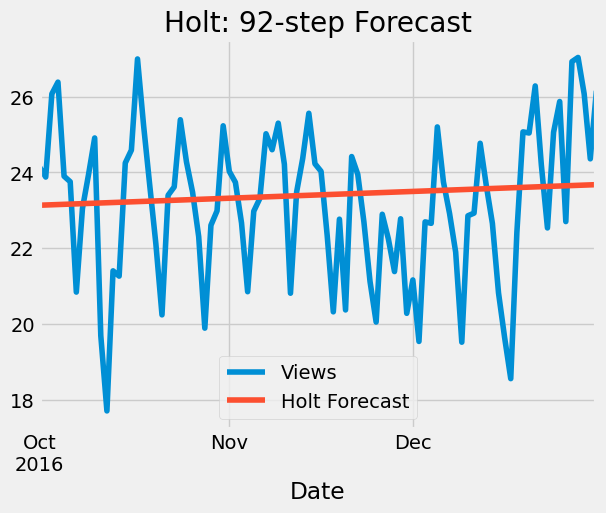

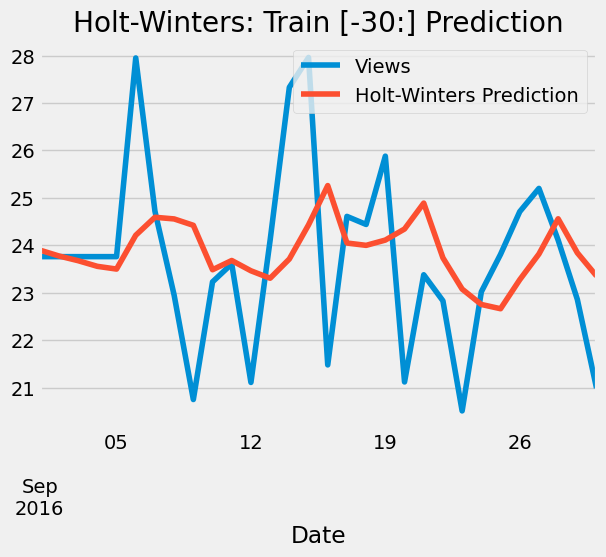

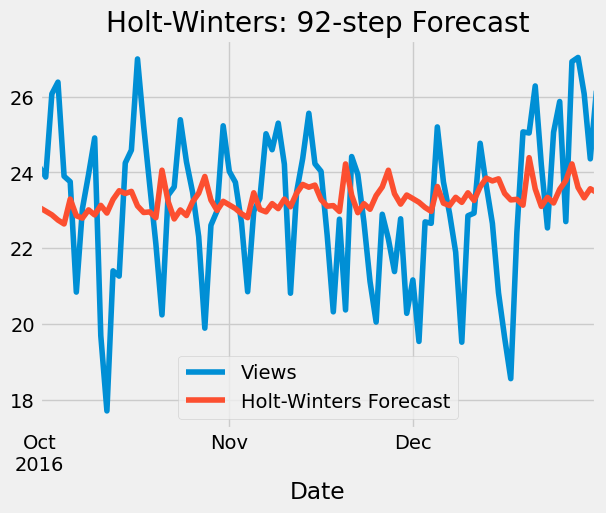

In [44]:
# Create a dictionary for model results
models = {
    'Simple ExpSmoothing': exp_smoothing_result,
    'Holt': holt_result,
    'Holt-Winters': hw_result
}

for name, result in models.items():
    # In-sample prediction (last 30 days of train)
    prediction = result.predict(start=train[-30:-29].index[0], end=train[-1:].index[0])
    # If the model provides conf_int (possible with HW for some versions):
    try:
        conf_int = result.conf_int()
    except AttributeError:
        conf_int = None
    
    fig, ax = plt.subplots()
    train[-30:].plot(ax=ax, label='Actual value')
    prediction.plot(ax=ax, label=f'{name} Prediction')
    
    if conf_int is not None:
        plt.fill_between(conf_int.index, conf_int['lower Views'], conf_int['upper Views'], color='grey', alpha=0.5)
    plt.legend()
    plt.title(f'{name}: Train [-30:] Prediction')
    plt.show()

    # Out-of-sample forecast (test set)
    forecast = result.predict(start=test.index[0], end=test.index[-1])
    fig, ax = plt.subplots()
    test.plot(ax=ax, label='Test')
    forecast.plot(ax=ax, label=f'{name} Forecast')
    
    # If conf_int is available, plot it
    if conf_int is not None:
        plt.fill_between(test.index, conf_int['lower Views'], conf_int['upper Views'], color='grey', alpha=0.5)
    plt.legend()
    plt.title(f'{name}: {test.shape[0]}-step Forecast')
    plt.show()


### Prophet

In [ ]:
train = pd.read_csv("train.csv", index_col=0, parse_dates=True)
test = pd.read_csv('test.csv', index_col=0, parse_dates=True)

(None, None)

In [17]:
train.shape, test.shape

((458, 1), (92, 1))

In [45]:
prophet_model = Prophet()
prophet_result = prophet_model.fit(train.reset_index().rename(columns={'Date':'ds', 'Views':'y'}))

20:23:42 - cmdstanpy - INFO - Chain [1] start processing
20:23:43 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
with open('model/prophet_model.json', 'w') as f:
    f.write(model_to_json(prophet_result))

In [90]:
with open('model/prophet_model.json', 'r') as f:
    prophet_model = model_from_json(f.read())

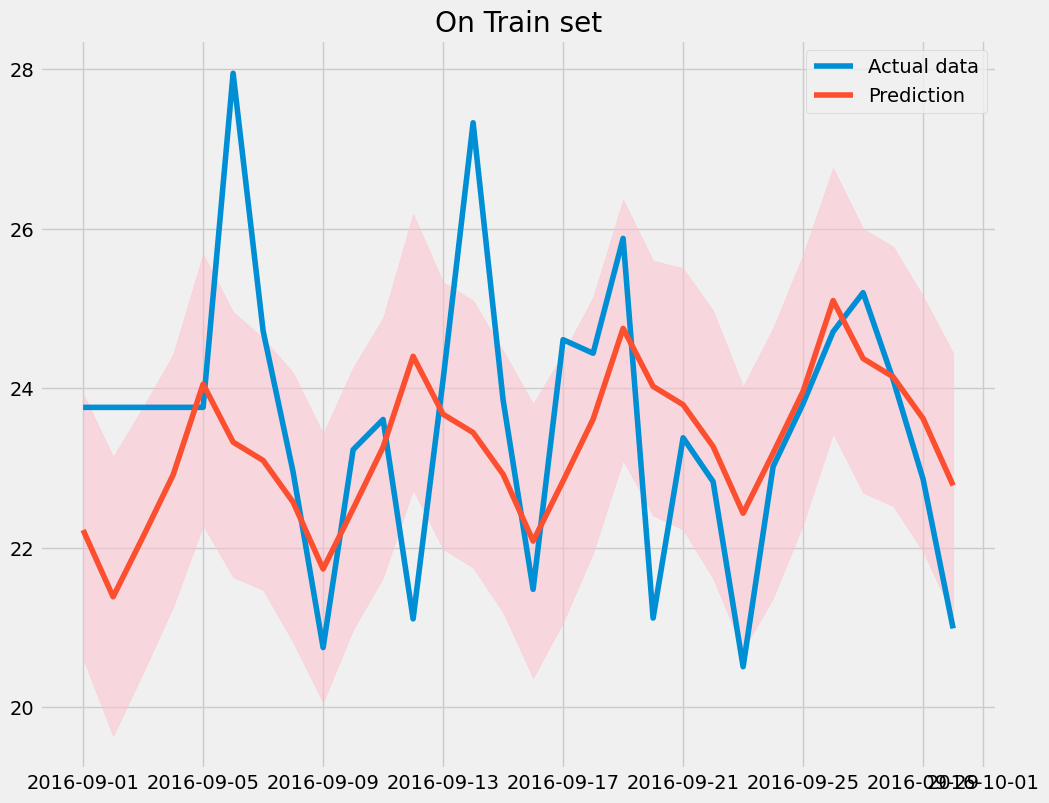

In [92]:
future = prophet_model.make_future_dataframe(periods=0)
prophet_prediction = prophet_model.predict(future)

prediction = prophet_prediction[['ds','yhat_lower','yhat_upper','yhat']][-30:]
plt.plot(train[-30:], label='Actual data')
plt.plot(prediction['ds'],prediction['yhat'],label='Prediction')
plt.fill_between(prediction['ds'],prediction['yhat_lower'],prediction['yhat_upper'],color='pink',alpha=0.5)
plt.legend(loc='best')
plt.title('On Train set')
plt.show()

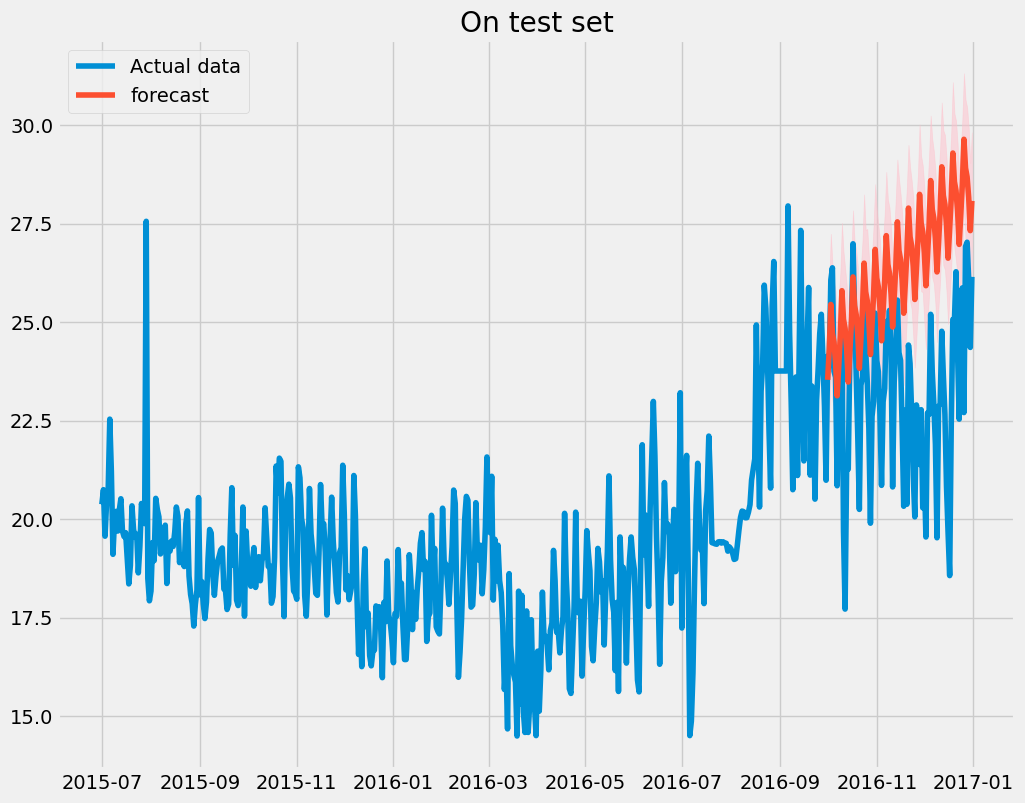

In [93]:
future = prophet_model.make_future_dataframe(periods=test.shape[0])
prophet_forecast = prophet_model.predict(future)

forecast = prophet_forecast[['ds','yhat_lower','yhat_upper','yhat']][-test.shape[0]:]
plt.plot(top_page_df, label='Actual data')
plt.plot(forecast['ds'],forecast['yhat'],label='forecast')
plt.fill_between(forecast['ds'],forecast['yhat_lower'],forecast['yhat_upper'],color='pink',alpha=0.5)
plt.legend(loc='best')
plt.title('On test set')
plt.show()

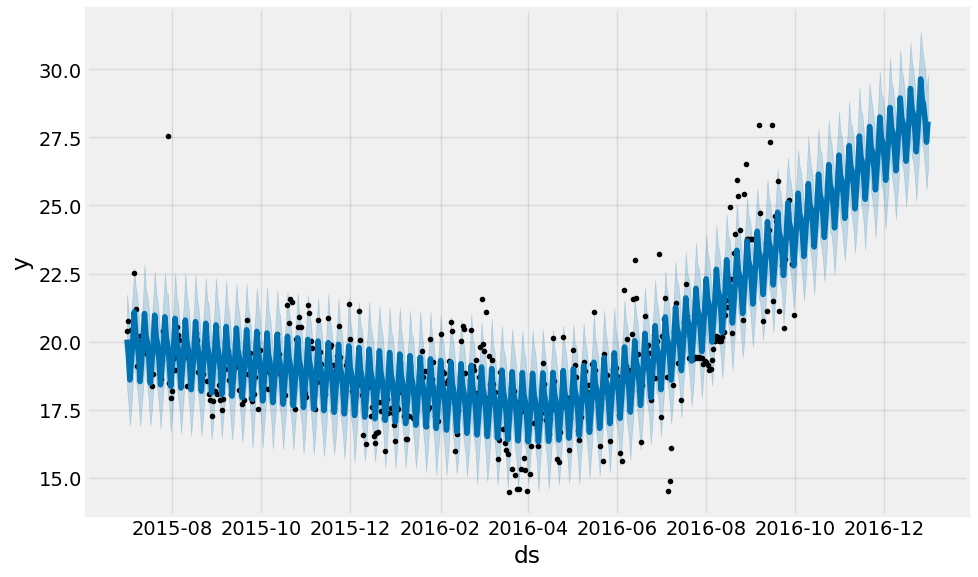

In [50]:
fig = prophet_model.plot(prophet_forecast)

In [67]:
np.sqrt(np.mean(np.square(forecast.yhat.values - test.Views.values)))

3.7777614264933677

### Auto Arima

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1692.440, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1667.747, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1622.513, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1690.440, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1573.906, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1570.744, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1660.484, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1548.947, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1632.225, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1538.563, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1597.826, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1529.502, Time=0.15 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1561.715, Time=0.09 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : 

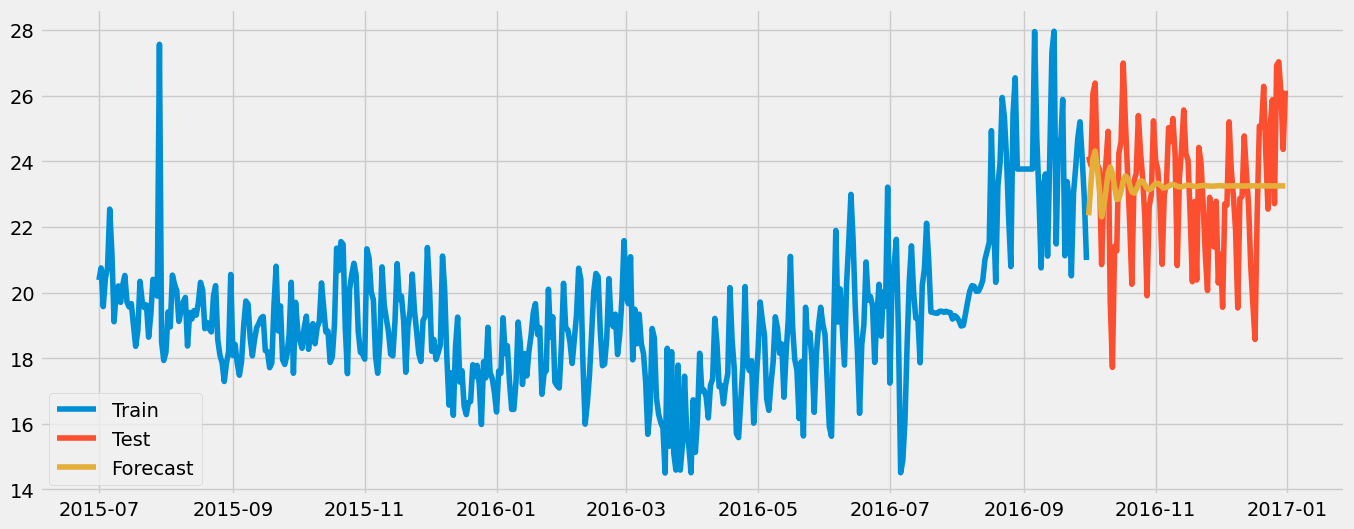

In [51]:
auto_arima_model = auto_arima(train,start_p=2,max_p=7,start_q=2,max_q=7, m=1,stationary=False,trace=True, seasonal=False,error_action='ignore',suppress_warnings=True)
auto_arima_model.fit(train)

auto_arima_forecast = auto_arima_model.predict(n_periods=test.shape[0])
auto_arima_forecast = pd.DataFrame(auto_arima_forecast,index = test.index,columns=['Forecast'])

plt.figure(figsize=(15,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(auto_arima_forecast, label='Forecast')
plt.legend()
plt.show()

In [52]:
with open('model/auto_arima_model.pkl', 'wb') as f:
    pickle.dump(auto_arima_model, f)

In [70]:
np.sqrt(np.mean(np.square(auto_arima_forecast.values - test.Views.values)))

2.015319620353315

### Deep learning models

In [4]:
train = pd.read_csv("train.csv", index_col=0, parse_dates=True)
test = pd.read_csv('test.csv', index_col=0, parse_dates=True)

In [5]:
train.head()

Views
Date             
2015-07-01  20.38
2015-07-02  20.75
2015-07-03  19.57
2015-07-04  20.44
2015-07-05  20.77

In [2]:
def transform_data(x, y, time_step=1):
    xs, ys = [], []

    for i in range(len(x) - time_step):
        v = x.iloc[i:(i + time_step)].values
        xs.append(v)
        ys.append(y.iloc[i + time_step])
    return np.array(xs), np.array(ys)
# time_steps = 7
# x_train, y_train = transform_data(train, train.Views, time_steps)
# x_test, y_test = transform_data(test, test.Views, time_steps)

In [54]:
for i in range(2):
    print(x_train[i])
    print('\n')
    print(x_test[i])
    print('\nNew')

[[20.38]
 [20.75]
 [19.57]
 [20.44]
 [20.77]
 [22.54]
 [21.21]]


[[24.14      ]
 [23.88      ]
 [26.07      ]
 [26.38      ]
 [23.90137931]
 [23.75678571]
 [20.85      ]]

New
[[20.75]
 [19.57]
 [20.44]
 [20.77]
 [22.54]
 [21.21]
 [19.11]]


[[23.88      ]
 [26.07      ]
 [26.38      ]
 [23.90137931]
 [23.75678571]
 [20.85      ]
 [23.05      ]]

New


In [55]:
x_train.shape

(451, 7, 1)

In [56]:
# model

def build_cnn_model(time_steps, n_features=1):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu',
                               input_shape=(time_steps, n_features)),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    return model

In [57]:
model = build_cnn_model(time_steps)

In [58]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 6, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         9,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,893 (38.64 KB)

 Trainable params: 9,893 (38.64 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True, 
    verbose=1
)

In [60]:
history = model.fit(x_train, y_train, epochs=20, verbose=1, shuffle=False,
                    callbacks=[early_stopping])

Epoch 1/20


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 103.3356  
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5849 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9189 
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0068 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4729 
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4255 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3763 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3760 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3603 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3496 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3201 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2809 
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2444 
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2074 
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1709 
Epoch 16/20


In [61]:
model2 = build_cnn_model(time_steps)
history2 = model2.fit(x_train, y_train, epochs=40, verbose=1, shuffle=False,
                    callbacks=[early_stopping])

Epoch 1/40


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 105.3119  
Epoch 2/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.4605 
Epoch 3/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3103 
Epoch 4/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8282 
Epoch 5/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5881 
Epoch 6/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4460 
Epoch 7/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4303 
Epoch 8/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3992 
Epoch 9/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3930 
Epoch 10/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3726 
Epoch 11/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3571 
Epoch 12/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3308 
Epoch 13/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3046 
Epoch 14/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2792 
Epoch 15/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2542 
Epoch 16/40

In [62]:
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

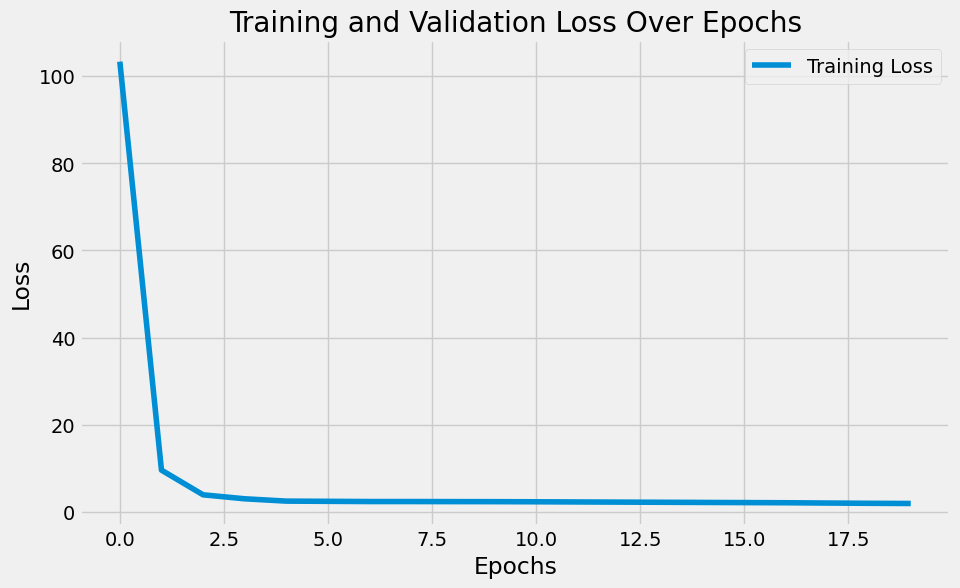

In [63]:
plot_training_history(history)

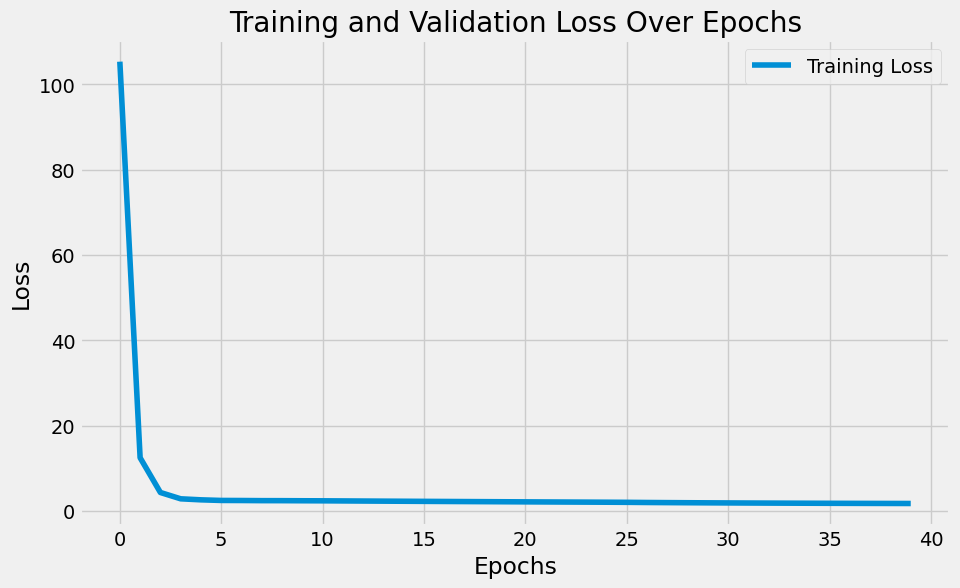

In [64]:
plot_training_history(history2)

In [65]:
y_pred = model.predict(x_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


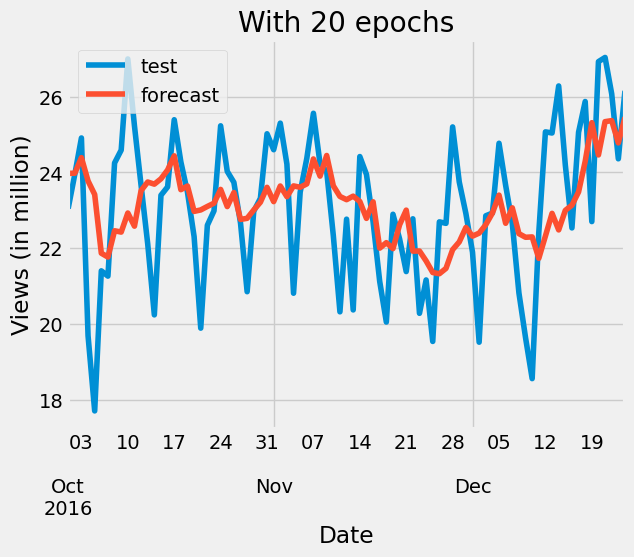

In [66]:
fig,ax=plt.subplots()
pd.DataFrame({'Date':test.index[:y_test.shape[0]],'Views':y_test}).plot('Date',ax=ax)
pd.DataFrame({'Date':test.index[:y_pred.shape[0]],'Views':y_pred.flatten()}).plot('Date',ax=ax)
plt.legend(['test', 'forecast'], loc='upper left')
plt.ylabel('Views (in million)')
plt.title('With 20 epochs')
plt.show()

In [67]:
print('RMSE:'+str(np.sqrt(np.mean(np.square(y_pred.flatten() - y_test)))))

RMSE:1.796786520330069


In [68]:
model.save('model/cnn_model.keras')

In [69]:
y_pred = model2.predict(x_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step 


In [70]:
print('RMSE:'+str(np.sqrt(np.mean(np.square(y_pred.flatten() - y_test)))))

RMSE:1.6670636471173463


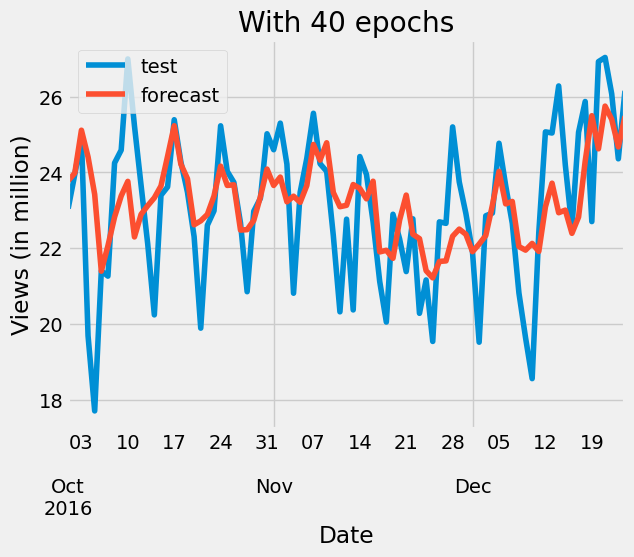

In [71]:
fig,ax=plt.subplots()
pd.DataFrame({'Date':test.index[:y_test.shape[0]],'Views':y_test}).plot('Date',ax=ax)
pd.DataFrame({'Date':test.index[:y_pred.shape[0]],'Views':y_pred.flatten()}).plot('Date',ax=ax)
plt.legend(['test', 'forecast'], loc='upper left')
plt.ylabel('Views (in million)')
plt.title('With 40 epochs')
plt.show()

In [72]:
model3 = build_cnn_model(time_steps)
history3 = model3.fit(x_train, y_train, epochs=60, verbose=1, shuffle=False,
                    callbacks=[early_stopping])

Epoch 1/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 227.5782  
Epoch 2/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.4651 
Epoch 3/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.7068  
Epoch 4/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9438 
Epoch 5/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3954 
Epoch 6/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3137 
Epoch 7/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2955 
Epoch 8/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2737 
Epoch 9/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2743 
Epoch 10/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2679 
Epoch 11/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2642 
Epoch 12/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2593 
Epoch 13/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2547 
Epoch 14/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2497 
Epoch 15/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2446 

In [73]:
y_pred = model3.predict(x_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [74]:
print('RMSE:'+str(np.sqrt(np.mean(np.square(y_pred.flatten() - y_test)))))

RMSE:1.7346764836139008


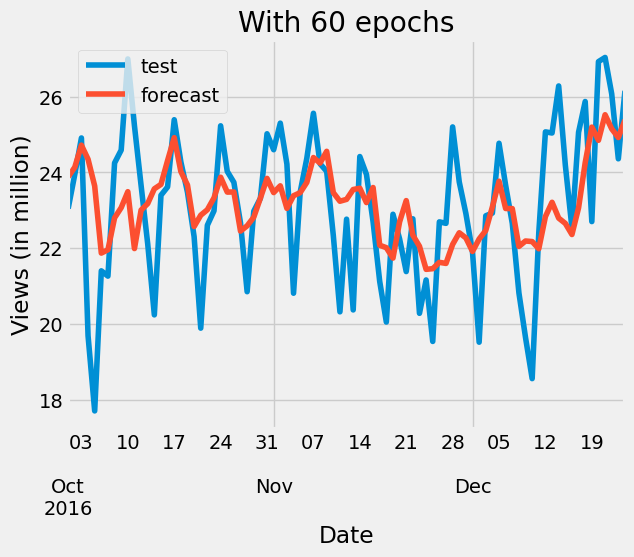

In [75]:
fig,ax=plt.subplots()
pd.DataFrame({'Date':test.index[:y_test.shape[0]],'Views':y_test}).plot('Date',ax=ax)
pd.DataFrame({'Date':test.index[:y_pred.shape[0]],'Views':y_pred.flatten()}).plot('Date',ax=ax)
plt.legend(['test', 'forecast'], loc='upper left')
plt.ylabel('Views (in million)')
plt.title('With 60 epochs')
plt.show()

In [76]:
model4 = build_cnn_model(time_steps)
history4 = model4.fit(x_train, y_train, epochs=100, verbose=1, shuffle=False,
                    callbacks=[early_stopping])

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 136.6276  
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6925 
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8100  
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9688 
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3171 
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2802 
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2420 
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2346 
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2255 
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2161 
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2060 
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1926 
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1743 
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1494 
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

In [77]:
y_pred = model4.predict(x_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [78]:
print('RMSE:'+str(np.sqrt(np.mean(np.square(y_pred.flatten() - y_test)))))

RMSE:1.6141346267653864


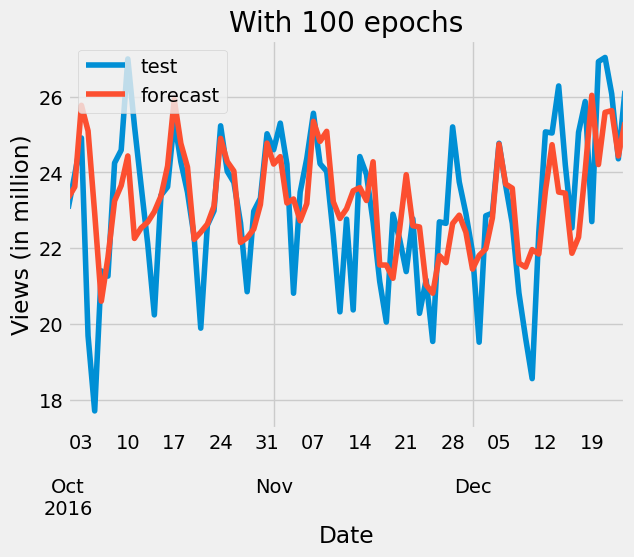

In [79]:
fig,ax=plt.subplots()
pd.DataFrame({'Date':test.index[:y_test.shape[0]],'Views':y_test}).plot('Date',ax=ax)
pd.DataFrame({'Date':test.index[:y_pred.shape[0]],'Views':y_pred.flatten()}).plot('Date',ax=ax)
plt.legend(['test', 'forecast'], loc='upper left')
plt.ylabel('Views (in million)')
plt.title('With 100 epochs')
plt.show()

In [80]:
model3.save("model/cnn_model_60_epochs.keras")

### Metric evaluations

In [8]:
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    non_zero_mask = y_true != 0
    if not np.any(non_zero_mask):
        return np.nan
    
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

def calculate_smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    ratio = np.zeros_like(y_true, dtype=float)
    non_zero_denominator_mask = denominator != 0
    ratio[non_zero_denominator_mask] = numerator[non_zero_denominator_mask] / denominator[non_zero_denominator_mask]
    
    return np.mean(ratio) * 100


def evaluate_model_metrics(y_true, y_pred, model_name="Model"):

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = calculate_mape(y_true, y_pred)
    smape = calculate_smape(y_true, y_pred)
    
    print(f"--- {model_name} Evaluation ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}%")
    print(f"SMAPE: {smape:.4f}%")
    
    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'SMAPE': smape}


In [4]:
test_df = pd.read_csv('test.csv', index_col=0, parse_dates=True)
y_true = test_df['Views']

In [16]:
all_model_results = []

# List of models to evaluate
models_to_evaluate = [
    {'name': 'ARMA', 'path': 'model/arma_model.pkl', 'type': 'pickle'},
    {'name': 'ARIMA', 'path': 'model/arima_model.pkl', 'type': 'pickle'},
    {'name': 'Auto ARIMA', 'path': 'model/auto_arima_model.pkl', 'type': 'pickle_auto_arima'}, # Changed type
    {'name': 'Simple Exp Smoothing', 'path': 'model/simple_exp_smoothing.pkl', 'type': 'pickle_exp_smoothing'}, # Changed type
    {'name': 'Holt Additive', 'path': 'model/holt_add.pkl', 'type': 'pickle_exp_smoothing'}, # Changed type
    {'name': 'Holt Additive Seasonal', 'path': 'model/holt_add_seasonal.pkl', 'type': 'pickle_exp_smoothing'}, # Changed type
    {'name': 'Prophet', 'path': 'model/prophet_model.json', 'type': 'prophet'},
    {'name': 'CNN Model (20 epochs)', 'path': 'model/cnn_model.keras', 'type': 'keras'},
    {'name': 'CNN Model (60 epochs)', 'path': 'model/cnn_model_60_epochs.keras', 'type': 'keras'},
]

# Prepare data for CNN models
time_steps = 7 

x_test_cnn, y_true_cnn = transform_data(test_df, test_df.Views, time_steps)

for model_info in models_to_evaluate:
    model_name = model_info['name']
    model_path = model_info['path']
    model_type = model_info['type']
    
    print(f"Loading and evaluating {model_name}...")
    
    try:
        if model_type == 'pickle': # For SARIMAXResultsWrapper (ARMA, ARIMA)
            with open(model_path, 'rb') as f:
                model = pickle.load(f)
            if isinstance(model, SARIMAXResultsWrapper):
                forecast_result = model.get_forecast(steps=len(y_true))
                y_pred = forecast_result.predicted_mean
            else:
                print(f"Warning: Unexpected pickle model type for {model_name}. Skipping prediction.")
                continue

        elif model_type == 'pickle_auto_arima':
            with open(model_path, 'rb') as f:
                model = pickle.load(f)
            if isinstance(model, ARIMA):
                y_pred = model.predict(n_periods=len(y_true))
                y_pred = pd.Series(y_pred, index=y_true.index) # Convert to Series with correct index
            else:
                print(f"Warning: Unexpected auto_arima model type for {model_name}. Skipping prediction.")
                continue

        elif model_type == 'pickle_exp_smoothing':
            with open(model_path, 'rb') as f:
                model = pickle.load(f)
            # ExponentialSmoothing models (SimpleExpSmoothing, Holt, Holt-Winters)
            # The loaded object is the fitted model, not the results wrapper directly
            # Need to call predict on the loaded model
            # The predict method for these models takes start and end dates
            y_pred = model.predict(start=y_true.index[0], end=y_true.index[-1])
            
        elif model_type == 'prophet':
            with open(model_path, 'r') as f:
                model = model_from_json(f.read())
            future = model.make_future_dataframe(periods=len(y_true), include_history=False)
            prophet_forecast = model.predict(future)
            y_pred = prophet_forecast['yhat']
            y_pred.index = y_true.index # Align index for evaluation

        elif model_type == 'keras':
            model = tf.keras.models.load_model(model_path)
            y_pred = model.predict(x_test_cnn).flatten()
            # Adjust y_true for CNN predictions to match the length of y_pred
            current_y_true = y_true_cnn
            
        else:
            print(f"Unknown model type: {model_type} for {model_name}. Skipping.")
            continue

        # Ensure y_pred and y_true have the same length and index for evaluation
        if model_type != 'keras':
            if len(y_pred) != len(y_true):
                print(f"Warning: Prediction length mismatch for {model_name}. Slicing y_pred.")
                y_pred = y_pred.iloc[:len(y_true)]
            if not y_pred.index.equals(y_true.index):
                print(f"Warning: Index mismatch for {model_name}. Reindexing y_pred.")
                y_pred = y_pred.reindex(y_true.index)
            
            results = evaluate_model_metrics(y_true, y_pred, model_name)
        else: # For Keras models, use the adjusted y_true_cnn
            results = evaluate_model_metrics(current_y_true, y_pred, model_name)
            
        all_model_results.append(results)

    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")

print("\n--- All Model Evaluation Results ---")
results_df = pd.DataFrame(all_model_results)
print(results_df.to_markdown(index=False))

Loading and evaluating ARMA...
--- ARMA Evaluation ---
RMSE: 1.7247
MAE: 1.2902
MAPE: 5.7573%
SMAPE: 5.6410%
Loading and evaluating ARIMA...
--- ARIMA Evaluation ---
RMSE: 1.7221
MAE: 1.2857
MAPE: 5.7375%
SMAPE: 5.6216%
Loading and evaluating Auto ARIMA...
--- Auto ARIMA Evaluation ---
RMSE: 1.9777
MAE: 1.5735
MAPE: 7.0129%
SMAPE: 6.8577%
Loading and evaluating Simple Exp Smoothing...
--- Simple Exp Smoothing Evaluation ---
RMSE: 2.1898
MAE: 1.8314
MAPE: 7.8309%
SMAPE: 7.9924%
Loading and evaluating Holt Additive...
--- Holt Additive Evaluation ---
RMSE: 2.0101
MAE: 1.6138
MAPE: 7.2248%
SMAPE: 7.0284%
Loading and evaluating Holt Additive Seasonal...
--- Holt Additive Seasonal Evaluation ---
RMSE: 2.0354
MAE: 1.6302
MAPE: 7.2686%
SMAPE: 7.0994%
Loading and evaluating Prophet...
--- Prophet Evaluation ---
RMSE: 3.7815
MAE: 3.2396
MAPE: 14.6445%
SMAPE: 13.2647%
Loading and evaluating CNN Model (20 epochs)...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
--- CNN Model (20 epochs) Evaluation ---
RM

In [62]:
results_df.to_json()

NameError: name 'results_df' is not defined

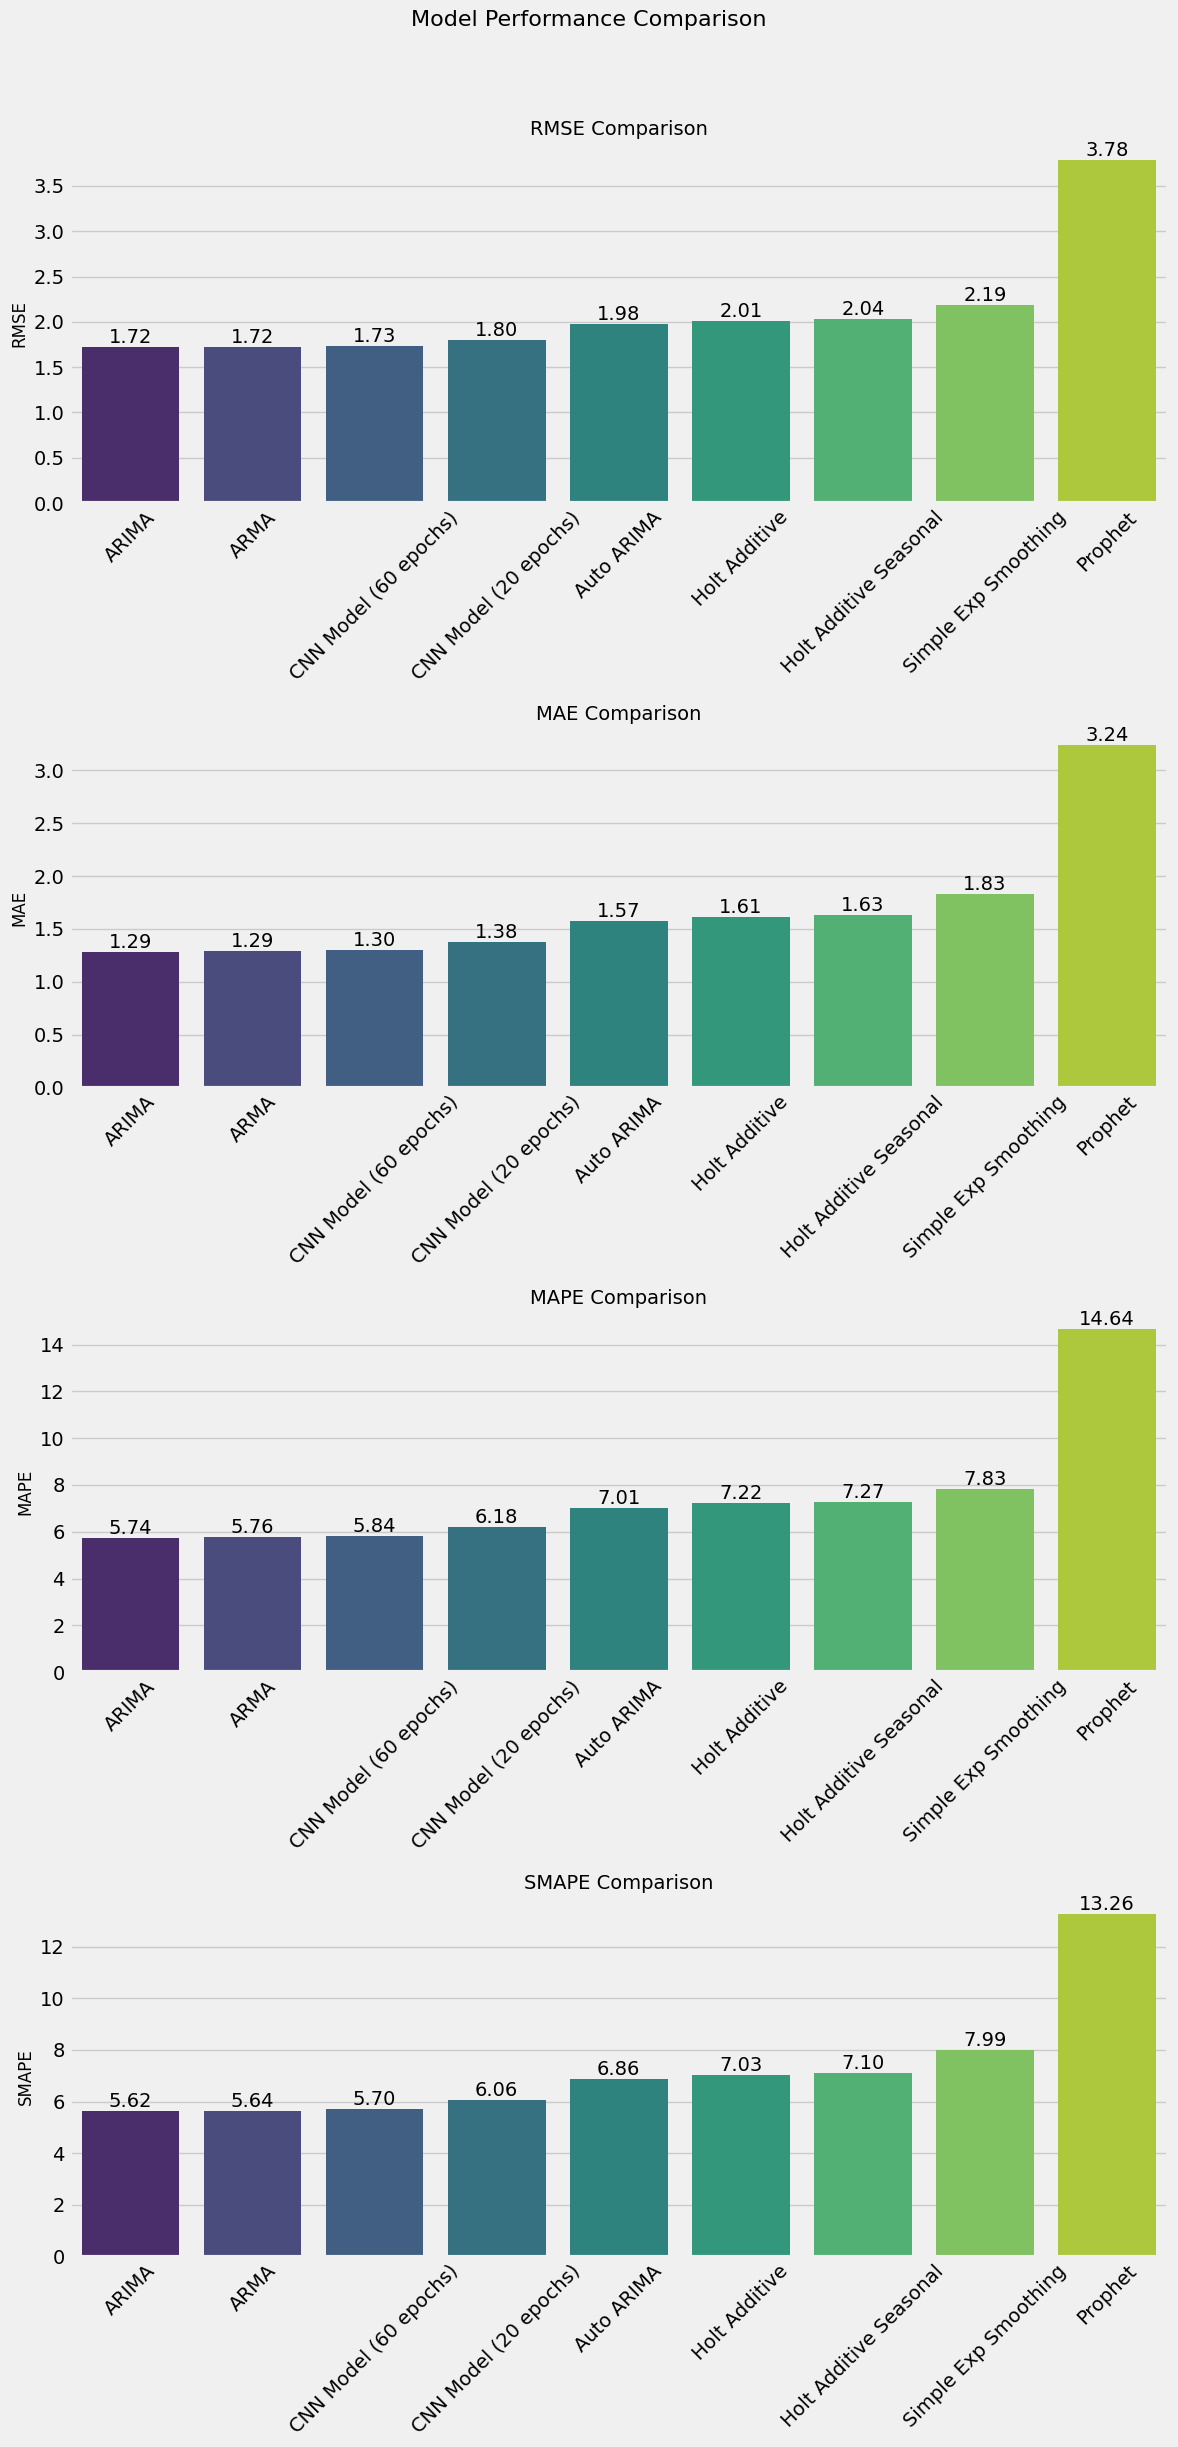

In [18]:
metrics = ['RMSE', 'MAE', 'MAPE', 'SMAPE']
results_df_sorted = results_df.sort_values(by='RMSE', ascending=True) # Sort by RMSE for better visualization

plt.style.use('fivethirtyeight') # Use a consistent style

fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 6 * len(metrics)))
fig.suptitle('Model Performance Comparison', fontsize=16, y=1.02)

for i, metric in enumerate(metrics):
    sns.barplot(x='Model', y=metric, data=results_df_sorted, ax=axes[i], palette='viridis')
    axes[i].set_title(f'{metric} Comparison', fontsize=14)
    axes[i].set_ylabel(metric, fontsize=12)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add value labels on top of bars
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%.2f')

plt.tight_layout()
plt.show()